# Prediction of Active Regulatory Regions
## Alice Schiavone

Project for the course *Bioinformatics* at *Università degli Studi di Milano Statale* held by Giorgio Valentini. Code and libraries from the [work](https://github.com/LucaCappelletti94/bioinformatics_practice) of Luca Cappelletti.


Working on the "HG38" dataset and the K562 cell line, we consider the following:
* Task 1: Active Enhancers vs Inactive Enhancers (AE vs IE)
* Task 2: Active Promoters vs Inactive Promoters (AP vs IP)

# Set up

In [3]:
# had issues installing MINEPY from pip, 
# so I got it from:   https://www.lfd.uci.edu/~gohlke/pythonlibs/#minepy
!pip install minepy/minepy-1.2.6-cp310-cp310-win_amd64.whl

Processing q:\github\crr_classification\minepy\minepy-1.2.6-cp310-cp310-win_amd64.whl


In [4]:
!pip install epigenomic_dataset ucsc_genomes_downloader keras_bed_sequence umap-learn tsnecuda tabulate
!pip install keras_bed_sequence keras_mixed_sequence -U
!pip install keras-tqdm extra_keras_metrics 

In [5]:
import numpy as np
import pandas as pd
import keras
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from epigenomic_dataset.utils import get_cell_lines

In [3]:
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning) 

# Data Retrieval

**Parameters**

In [6]:
cell_line = "K562"
genome = "hg38"

window_size = 256

enchancer_t = 0.0 # threshold
promoter_t  = 0.0 # threshold

Via the [Epigenomic Dataset](https://github.com/AnacletoLAB/epigenomic_dataset) data wrapper we download the promoters and enhancers data from [FANTOM5](https://fantom.gsc.riken.jp/) with the expression value (TPMs) of each gene.

In [7]:
from tqdm.auto import tqdm
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers, active_promoters_vs_inactive_promoters

data = dict()

tasks = [
  ('enhancers', active_enhancers_vs_inactive_enhancers, enchancer_t),
  ('promoters', active_promoters_vs_inactive_promoters, promoter_t)
]

for task, function, threshold in tqdm(tasks, desc="Data Retrieval"):
  X, y = function(
      #binarize = True,
      cell_line = cell_line,
      window_size = window_size,
      #min_active_tpm_value=threshold,
      #max_inactive_tpm_value=threshold
  )
  data[task] = {'X':X, 'y':y}
  data[task]['training_history'] = {}
  data[task]['evaluation'] = {}
  data[task]['features_to_remove'] = set()

  print(
      f'Task "{function.__name__}" has:\n'
      f'-  X.shape {X.shape} and y.shape {y.shape}\n'
      f'-  Rate between features and samples: {X.shape[0] / X.shape[1]}\n'
      f'-  Number of NaN values: {X.isna().values.sum()}\n'
      f'   The average of missing values for the samples is {X.isna().sum(axis=1).mean():0.5f}, for the features it is {X.isna().sum(axis=0).mean():0.5f}\n'
  )

Data Retrieval:   0%|          | 0/2 [00:00<?, ?it/s]

Task "active_enhancers_vs_inactive_enhancers" has:
-  X.shape (63285, 429) and y.shape (63285, 1)
-  Rate between features and samples: 147.5174825174825
-  Number of NaN values: 102
   The average of missing values for the samples is 0.00161, for the features it is 0.23776

Task "active_promoters_vs_inactive_promoters" has:
-  X.shape (99881, 429) and y.shape (99881, 1)
-  Rate between features and samples: 232.82284382284382
-  Number of NaN values: 496
   The average of missing values for the samples is 0.00497, for the features it is 1.15618



# Data Exploration and Preprocessing

In [8]:
for task in data.keys(): 
  print(task)
  display(data[task]['X'].describe())

enhancers


chrom,SMAD5,NCOA2,ZNF23,NR2F6,CEBPZ,SNIP1,ZBTB7A,ZNF133,NRF1,TAF1,...,SIN3A,SMARCC2,ZFP91,E2F4,NR3C1,SAFB2,E4F1,NCOR1,NCOA1,KLF1
count,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63284.000000,63285.000000,63285.000000,63284.000000,...,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000
mean,0.854204,0.743733,0.831215,0.800811,0.864409,0.804661,1.245513,0.907048,1.021286,1.101227,...,0.929765,0.976732,0.862212,1.429998,0.810822,0.649336,1.008343,1.075286,0.808300,0.942412
std,0.878816,0.334574,0.532511,0.334844,0.581483,0.453880,2.228033,0.464311,4.122830,2.245365,...,0.825980,0.777798,1.610566,2.560798,0.425050,0.509271,1.594609,1.834175,0.520243,0.563087
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.460000,0.520000,0.470000,0.590000,0.510000,0.490000,0.310000,0.580000,0.450000,0.000000,...,0.530000,0.480000,0.510000,0.060000,0.510000,0.270000,0.470000,0.450000,0.480000,0.610000
50%,0.720000,0.720000,0.740000,0.780000,0.800000,0.770000,0.690000,0.850000,0.660000,0.530000,...,0.780000,0.820000,0.760000,0.830000,0.770000,0.550000,0.780000,0.770000,0.770000,0.870000
75%,1.030000,0.930000,1.080000,0.980000,1.140000,1.060000,1.350000,1.160000,0.920000,1.280000,...,1.110000,1.260000,1.050000,1.800000,1.060000,0.930000,1.200000,1.200000,1.080000,1.170000
max,35.750000,6.470000,28.540000,7.480000,47.370000,21.400000,68.250000,9.480000,242.180000,64.490000,...,24.170000,11.920000,141.530000,96.300000,5.020000,4.700000,175.740000,111.920000,37.360000,34.320000


promoters


chrom,SMAD5,NCOA2,ZNF23,NR2F6,CEBPZ,SNIP1,ZBTB7A,ZNF133,NRF1,TAF1,...,SIN3A,SMARCC2,ZFP91,E2F4,NR3C1,SAFB2,E4F1,NCOR1,NCOA1,KLF1
count,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,...,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000
mean,2.238571,0.657735,0.879565,0.860949,1.241882,0.831541,3.811772,1.017048,8.070131,6.555876,...,2.409723,0.981741,1.510206,7.417156,0.797512,0.601236,2.889943,1.165788,0.699335,1.298927
std,2.650387,0.930009,0.589551,0.391718,2.192965,1.723633,5.233189,0.522413,23.177855,10.750923,...,2.873567,0.686464,6.726482,13.299242,0.500373,0.441843,16.807033,1.482469,0.462811,1.111308
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.620000,0.410000,0.460000,0.620000,0.560000,0.390000,0.760000,0.650000,0.570000,0.450000,...,0.680000,0.490000,0.520000,0.870000,0.440000,0.280000,0.490000,0.440000,0.370000,0.660000
50%,1.100000,0.600000,0.790000,0.830000,0.950000,0.690000,1.910000,0.960000,1.040000,1.760000,...,1.230000,0.890000,0.860000,2.560000,0.760000,0.530000,1.010000,0.880000,0.650000,1.040000
75%,3.070000,0.800000,1.190000,1.060000,1.450000,1.020000,4.810000,1.310000,3.560000,8.560000,...,3.270000,1.350000,1.260000,9.110000,1.090000,0.840000,2.210000,1.510000,0.970000,1.620000
max,55.770000,38.470000,24.840000,16.170000,78.080000,148.680000,116.890000,7.420000,428.950000,226.500000,...,51.440000,12.940000,353.440000,325.240000,9.970000,3.860000,914.370000,66.960000,11.170000,46.240000


Value distribution

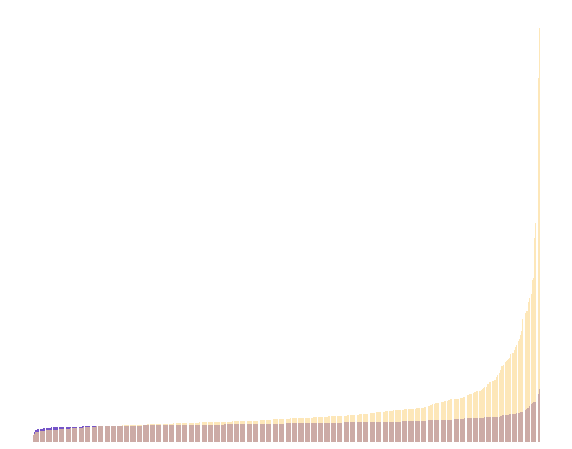

In [9]:
colors = ['#7554c8','#fcdb94']
plt.figure(figsize=(10,8))

for j, task, color in zip([1,0.65], data.keys(), colors):
  mean_features = sorted(np.mean(data[task]['X'], axis=0))
  plt.bar([x for x in range(len(mean_features))], mean_features,
          alpha=j, color=color)
plt.axis("off")
plt.show()

### Imputation and costant values

Fill NaN values (data imputation) with K-Nearest Neighbors with a euclidean distance from sklearn KNNImputer.

In [10]:
from sklearn.impute import KNNImputer

def knn_imputation(df:pd.DataFrame, neighbours:int=5)->pd.DataFrame:
    """Return provided dataframe with NaN imputed using knn.
    
    Parameters
    --------------------
    df:pd.DataFrame,
        The dataframe to impute.
    neighbours:int=5,
        The number of neighbours to consider.
        
    Returns
    --------------------
    The dataframe with the NaN values imputed.
    """
    return pd.DataFrame(
        KNNImputer(n_neighbors=neighbours).fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

for task in data.keys():
  data[task]['X'] = knn_imputation(data[task]['X'])
  print('After imputing:')
  print(f"- NaN values for {task}: {data[task]['X'].isna().values.sum()}")

After imputing:
- NaN values for enhancers: 0
After imputing:
- NaN values for promoters: 0


Drop features with constant values which do not add any information. In our case, no feature is dropped.

In [11]:
def drop_constant_features(df:pd.DataFrame)->pd.DataFrame:
    """Return DataFrame without constant features."""
    print(f"Before drop shape: ", df.shape)
    df = df.loc[:, (df != df.iloc[0]).any()]
    print(f"After drop shape: ", df.shape)
    return df

for task in data.keys():
  data[task]['X'] = drop_constant_features(data[task]['X'])

Before drop shape:  (63285, 429)
After drop shape:  (63285, 429)
Before drop shape:  (99881, 429)
After drop shape:  (99881, 429)


### Robust z-scoring

In order to scale values in a robust fashion, we substruct the median and divide by the standard deviation $\sigma$ between the interquantile range $IQR=Q_3-Q_1$. A convenient sklearn function can be used for it.

In [12]:
from sklearn.preprocessing import RobustScaler

def robust_zscoring(df:pd.DataFrame)->pd.DataFrame:
    """Return given dataframe scaled using robust z-scoring."""
    return pd.DataFrame(
        RobustScaler().fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

for task in data.keys():
  data[task]['X'] = robust_zscoring(data[task]['X'])

In [13]:
for task in data.keys(): 
  print(task)
  display(data[task]['X'].describe())

enhancers


chrom,SMAD5,NCOA2,ZNF23,NR2F6,CEBPZ,SNIP1,ZBTB7A,ZNF133,NRF1,TAF1,...,SIN3A,SMARCC2,ZFP91,E2F4,NR3C1,SAFB2,E4F1,NCOR1,NCOA1,KLF1
count,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,...,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000
mean,0.235445,0.057884,0.149533,0.053362,0.102236,0.060809,0.534129,0.098359,0.768693,0.446258,...,0.258215,0.200939,0.189282,0.344826,0.074222,0.150509,0.312798,0.407047,0.063833,0.129307
std,1.541783,0.816035,0.872969,0.858575,0.922989,0.796281,2.142327,0.800536,8.771979,1.754181,...,1.424104,0.997177,2.982530,1.471723,0.772818,0.771623,2.184396,2.445567,0.867071,1.005512
min,-1.263158,-1.756098,-1.213115,-2.000000,-1.269841,-1.350877,-0.663462,-1.465517,-1.404255,-0.414062,...,-1.344828,-1.051282,-1.407407,-0.477011,-1.400000,-0.833333,-1.068493,-1.026667,-1.283333,-1.553571
25%,-0.456140,-0.487805,-0.442623,-0.487179,-0.460317,-0.491228,-0.365385,-0.465517,-0.446809,-0.414062,...,-0.431034,-0.435897,-0.462963,-0.442529,-0.472727,-0.424242,-0.424658,-0.426667,-0.483333,-0.464286
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.543860,0.512195,0.557377,0.512821,0.539683,0.508772,0.634615,0.534483,0.553191,0.585938,...,0.568966,0.564103,0.537037,0.557471,0.527273,0.575758,0.575342,0.573333,0.516667,0.535714
max,61.456140,14.024390,45.573770,17.179487,73.920635,36.192982,64.961538,14.879310,513.872340,49.968750,...,40.327586,14.230769,260.685185,54.867816,7.727273,6.287879,239.671233,148.200000,60.983333,59.732143


promoters


chrom,SMAD5,NCOA2,ZNF23,NR2F6,CEBPZ,SNIP1,ZBTB7A,ZNF133,NRF1,TAF1,...,SIN3A,SMARCC2,ZFP91,E2F4,NR3C1,SAFB2,E4F1,NCOR1,NCOA1,KLF1
count,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,...,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000,99881.000000
mean,0.464723,0.148039,0.122691,0.070339,0.327957,0.224668,0.469573,0.086437,2.351214,0.591353,...,0.455491,0.106675,0.878657,0.589461,0.057710,0.127207,1.092990,0.267092,0.082225,0.269716
std,1.081791,2.384639,0.807604,0.890268,2.464006,2.735925,1.292145,0.791534,7.751791,1.325638,...,1.109485,0.798214,9.089841,1.613986,0.769805,0.789006,9.771531,1.385485,0.771351,1.157613
min,-0.448980,-1.538462,-1.082192,-1.886364,-1.067416,-1.095238,-0.471605,-1.454545,-0.347826,-0.217016,...,-0.474903,-1.034884,-1.162162,-0.310680,-1.169231,-0.946429,-0.587209,-0.822430,-1.083333,-1.083333
25%,-0.195918,-0.487179,-0.452055,-0.477273,-0.438202,-0.476190,-0.283951,-0.469697,-0.157191,-0.161529,...,-0.212355,-0.465116,-0.459459,-0.205097,-0.492308,-0.446429,-0.302326,-0.411215,-0.466667,-0.395833
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.804082,0.512821,0.547945,0.522727,0.561798,0.523810,0.716049,0.530303,0.842809,0.838471,...,0.787645,0.534884,0.540541,0.794903,0.507692,0.553571,0.697674,0.588785,0.533333,0.604167
max,22.314286,97.102564,32.945205,34.863636,86.662921,234.904762,28.390123,9.787879,143.113712,27.711467,...,19.386100,14.011628,476.459459,39.160194,14.169231,5.946429,531.023256,61.757009,17.533333,47.083333


### Label binarization
based on selected thresholds

In [14]:
from sklearn.preprocessing import MinMaxScaler

def binarize(y:pd.DataFrame, clip_value:float)->pd.DataFrame:
  labels = data[task]['y'].values
  labels = MinMaxScaler(feature_range=(0, 1)).fit_transform(labels)
  labels = np.where(labels > clip_value, 1, 0)
  return pd.DataFrame(labels, index=data[task]['y'].index, columns=['K562']).astype(float)

for task, clip_value in zip(data.keys(), [enchancer_t, promoter_t]): data[task]['binary_y'] = binarize(data[task]['y'], clip_value)

for task in data.keys():
  value_count = np.unique(data[task]['binary_y'], return_counts=True)[1]
  print(f'For {task}:\n'
        f'-  Distribution of the labels (F/T): {value_count}\n'
        f'   So a ratio of {value_count[1]/value_count[0]:0.3f} Positives to Negatives with threshold {threshold}'
  )

For enhancers:
-  Distribution of the labels (F/T): [57761  5524]
   So a ratio of 0.096 Positives to Negatives with threshold 0.0
For promoters:
-  Distribution of the labels (F/T): [66346 33535]
   So a ratio of 0.505 Positives to Negatives with threshold 0.0


# Feature selection

### Correlation with the output

To reduce dimensionality and have a faster training, we want to drop features that are not correlated to the output, neither positive nor negative. 

Because not all relations are linear or monotonic, we first start by dropping features not relevant to the task with respect to the Pearson's and Spearman's coefficients, but then we compute non-linear scores.

In [15]:
p_value_threshold = 0.01
correlation_threshold = 0.05

In [16]:
from scipy.stats import pearsonr

for task in data.keys():
  X = data[task]['X']
  y = data[task]['y']
  print(f"\nTask: ", task)
  for feature in tqdm(X.columns, desc=f"Running Pearson test", dynamic_ncols=True, leave=False):
      correlation, p_value = pearsonr(X[feature].values.flatten(), y.values.flatten())
      if p_value > p_value_threshold:
          print(f"The feature {feature} does not correlate in a statistically significant manner with the output.")
          data[task]['features_to_remove'].add(feature)


Task:  enhancers


Running Pearson test:   0%|                                                                    | 0/429 [00:00<…

The feature STAG1 does not correlate in a statistically significant manner with the output.
The feature XRCC3 does not correlate in a statistically significant manner with the output.
The feature ILK does not correlate in a statistically significant manner with the output.
The feature ZNF830 does not correlate in a statistically significant manner with the output.
The feature HNRNPH1 does not correlate in a statistically significant manner with the output.
The feature RBM17 does not correlate in a statistically significant manner with the output.
The feature NR0B1 does not correlate in a statistically significant manner with the output.
The feature whole-genome shotgun bisulfite sequencing does not correlate in a statistically significant manner with the output.
The feature ZNF778 does not correlate in a statistically significant manner with the output.
The feature H4K20me1 does not correlate in a statistically significant manner with the output.
The feature SNRNP70 does not correlate 

Running Pearson test:   0%|                                                                    | 0/429 [00:00<…

The feature ZKSCAN3 does not correlate in a statistically significant manner with the output.
The feature ZNF785 does not correlate in a statistically significant manner with the output.
The feature U2AF2 does not correlate in a statistically significant manner with the output.
The feature RBM17 does not correlate in a statistically significant manner with the output.
The feature ARID2 does not correlate in a statistically significant manner with the output.
The feature ZBTB33 does not correlate in a statistically significant manner with the output.
The feature ZNF408 does not correlate in a statistically significant manner with the output.
The feature RFX1 does not correlate in a statistically significant manner with the output.
The feature EHMT2 does not correlate in a statistically significant manner with the output.
The feature ZBTB8A does not correlate in a statistically significant manner with the output.
The feature MIER1 does not correlate in a statistically significant manner 

In [17]:
from scipy.stats import spearmanr

for task in data.keys():
  X = data[task]['X']
  y = data[task]['y']
  print(f"\nTask: ", task)
  for feature in tqdm(X.columns, desc=f"Running Spearman test", dynamic_ncols=True, leave=False):
      correlation, p_value = spearmanr(X[feature].values.flatten(), y.values.flatten())
      if p_value > p_value_threshold:
          print(f"The feature {feature} does not correlate in a statistically significant manner with the output.")
          data[task]['features_to_remove'].add(feature)


Task:  enhancers


Running Spearman test:   0%|                                                                   | 0/429 [00:00<…

The feature SUZ12 does not correlate in a statistically significant manner with the output.
The feature U2AF2 does not correlate in a statistically significant manner with the output.
The feature RBM17 does not correlate in a statistically significant manner with the output.
The feature FOXJ3 does not correlate in a statistically significant manner with the output.
The feature SRSF7 does not correlate in a statistically significant manner with the output.
The feature DLX4 does not correlate in a statistically significant manner with the output.
The feature EWSR1 does not correlate in a statistically significant manner with the output.
The feature TSC22D4 does not correlate in a statistically significant manner with the output.
The feature MCM7 does not correlate in a statistically significant manner with the output.

Task:  promoters


Running Spearman test:   0%|                                                                   | 0/429 [00:00<…

The feature ZNF785 does not correlate in a statistically significant manner with the output.
The feature ARHGAP35 does not correlate in a statistically significant manner with the output.


In [18]:
for task in data.keys(): print(task, data[task]['features_to_remove'])

enhancers {'TSC22D4', 'ATF2', 'RBM17', 'SAFB2', 'YBX1', 'STAG1', 'SNRNP70', 'ILK', 'ZNF830', 'MCM7', 'U2AF2', 'FOXJ3', 'CEBPG', 'RFX1', 'XRCC3', 'whole-genome shotgun bisulfite sequencing', 'FOXA1', 'HNRNPH1', 'ZNF318', 'ZNF280A', 'ZNF778', 'MCM2', 'PCBP2', 'ZBTB8A', 'SUZ12', 'H4K20me1', 'RBM15', 'SRSF7', 'EWSR1', 'DLX4', 'NR0B1'}
promoters {'RBM17', 'MIER1', 'ZKSCAN3', 'U2AF2', 'EHMT2', 'ZNF408', 'RFX1', 'ZNF319', 'NCOA1', 'ZBTB33', 'NCOA4', 'ZBTB8A', 'SMARCA5', 'ZNF512', 'ARHGAP35', 'ZNF785', 'KLF10', 'PTRF', 'ARID2'}


Compute Non-Linear Correlations for the features that do not appear correlated with the output with Pearson's and Spearman's, but could have relationships which are not linear or monotonic. We remove them from the 'features_to_remove' set if that's the case.

In [19]:
from minepy import MINE

def compute_MINE():
  for task in data.keys():
    X = data[task]['X']
    y = data[task]['y']
    print(f"\nTask: ", task)
    for feature in tqdm(data[task]['features_to_remove'], desc=f"Running MINE test", dynamic_ncols=True, leave=False):
        mine = MINE()
        mine.compute_score(X[feature].values.ravel(), y.values.ravel())
        score = mine.mic()
        if score < correlation_threshold:
            print(f"The feature {feature} does not correlate in a statistically significant manner with the output.")
            data[task]['features_to_remove'].add(feature)
        else:
            print(f"*** The feature {feature} does correlate in a statistically significant manner with the output.")
            data[task]['features_to_remove'].minus(feature)

compute_MINE()


Task:  enhancers


Running MINE test:   0%|                                                                        | 0/31 [00:00<…

The feature TSC22D4 does not correlate in a statistically significant manner with the output.
The feature ATF2 does not correlate in a statistically significant manner with the output.
The feature RBM17 does not correlate in a statistically significant manner with the output.
The feature SAFB2 does not correlate in a statistically significant manner with the output.
The feature YBX1 does not correlate in a statistically significant manner with the output.
The feature STAG1 does not correlate in a statistically significant manner with the output.
The feature SNRNP70 does not correlate in a statistically significant manner with the output.
The feature ILK does not correlate in a statistically significant manner with the output.
The feature ZNF830 does not correlate in a statistically significant manner with the output.
The feature MCM7 does not correlate in a statistically significant manner with the output.
The feature U2AF2 does not correlate in a statistically significant manner with 

Running MINE test:   0%|                                                                        | 0/19 [00:00<…

The feature RBM17 does not correlate in a statistically significant manner with the output.
The feature MIER1 does not correlate in a statistically significant manner with the output.
The feature ZKSCAN3 does not correlate in a statistically significant manner with the output.
The feature U2AF2 does not correlate in a statistically significant manner with the output.
The feature EHMT2 does not correlate in a statistically significant manner with the output.
The feature ZNF408 does not correlate in a statistically significant manner with the output.
The feature RFX1 does not correlate in a statistically significant manner with the output.
The feature ZNF319 does not correlate in a statistically significant manner with the output.
The feature NCOA1 does not correlate in a statistically significant manner with the output.
The feature ZBTB33 does not correlate in a statistically significant manner with the output.
The feature NCOA4 does not correlate in a statistically significant manner w

Now compute correlations between features, which we want to be low because it would mean we have no repetition in the information. We can do it only for the features which were not removed to save a bit of time.

In [17]:
for task in data.keys():
  before_shape = data[task]['X'].shape
  data[task]['X'] = data[task]['X'].drop(labels=list(data[task]['features_to_remove']), axis=1)
  data[task]['features_to_remove'] = set()

In [ ]:
from cache_decorator import Cache

@Cache(
    cache_path="correlations/features/{_hash}.json",
    args_to_ignore=["X"]
)
def compute_correlation(
    f:function,
    X:pd.DataFrame,
    feature_left: str,
    feature_right: str
) -> dict:
    """Returns correlation based on some function.
    
    Parameters
    ----------------------
    X:pd.DataFrame,
        The epigenomic data.
    f:function,
        The linear correlation function to compute.
    feature_left: str,
        The left features to compute pearson for.
    feature_right: str,
        The right features to compute pearson for.
    """
    correlation, p_value = f(
        X[feature_left].values.flatten(),
        X[feature_right].values.flatten(),
    )
    return dict(
        correlation=correlation,
        p_value=p_value
    )

p_value_threshold_btw_features = 0.01 # we would drop these features if the correlation was high
correlation_threshold = 0.99

def correlation_btw_features():
  for task in data.keys():
    X = data[task]['X']
    y = data[task]['y']
    print(f"\nTask: ", task)
    for feature_left in tqdm(X.columns, desc=f"Running Pearson and Spearman test", dynamic_ncols=True, leave=False):
        for feature_right in X.columns:
            if feature_left >= feature_right:
                # Since the pearson (but not spearman) correlation is symmetric, we do not need to check
                # for the entire squared matrix of features but the upper triangular one
                # is sufficient.
                continue
            pearson_result = compute_correlation(pearsonr, X, feature_left, feature_right)
            if pearson_result["p_value"] < p_value_threshold_btw_features and np.abs(pearson_result["correlation"]) > correlation_threshold:
                correlation = pearson_result["correlation"]
                print(f"Pearson --- The feature {feature_left} is highly correlated with {feature_right} ({correlation:.3f}).")
                data[task]['features_to_remove'].add(feature_left)

        for feature_right in X.columns:
            if feature_left == feature_right:
              continue # of course the same feature is correlated to itself
            spearman_result = compute_correlation(spearmanr, X, feature_left, feature_right)
            if spearman_result["p_value"] < p_value_threshold_btw_features and np.abs(spearman_result["correlation"]) > correlation_threshold:
                correlation = spearman_result["correlation"]
                print(f"Spearman --- The feature {feature_left} is highly correlated with {feature_right} ({correlation:.3f}).")
                data[task]['features_to_remove'].add(feature_left)

#correlation_btw_features()

In [18]:
for task in data.keys():
  print(f"{task} shape before: {before_shape}")
  data[task]['X'] = data[task]['X'].drop(labels=list(data[task]['features_to_remove']), axis=1)
  print(f"{task} shape after: {data[task]['X'].shape}")

enhancers shape before: (99881, 429)
enhancers shape after: (63285, 398)
promoters shape before: (99881, 429)
promoters shape after: (99881, 410)


### Feature selection with Random Forests

Use a Random Forest Classifier to extract the most important features. We run the model multiple times to have significant results. 

In [19]:
from sklearn.ensemble import RandomForestClassifier

n_runs = 3

for task in data.keys():
  data[task]['feature_selection'] = {}
  X, y = data[task]['X'], np.ravel(data[task]['binary_y'])

  for i in tqdm(range(n_runs), desc = f"Feature selection - {task}"):
    model = RandomForestClassifier(
        criterion='gini',
        n_jobs=-1, # use all processors
        random_state=42,
        warm_start=False
    )
    model.fit(X, y)
    importance = model.feature_importances_
    data[task]['feature_selection'][i] = importance

Feature selection - enhancers:   0%|          | 0/3 [00:00<?, ?it/s]

Feature selection - promoters:   0%|          | 0/3 [00:00<?, ?it/s]

Compute :
* the mean importance between the n-runs per task
* the median importance of features per task (to be robust to outliers)

and plot with a log-scaled y-axis the n-runs with a line to represent the median. Keep only the features with importance above the line.

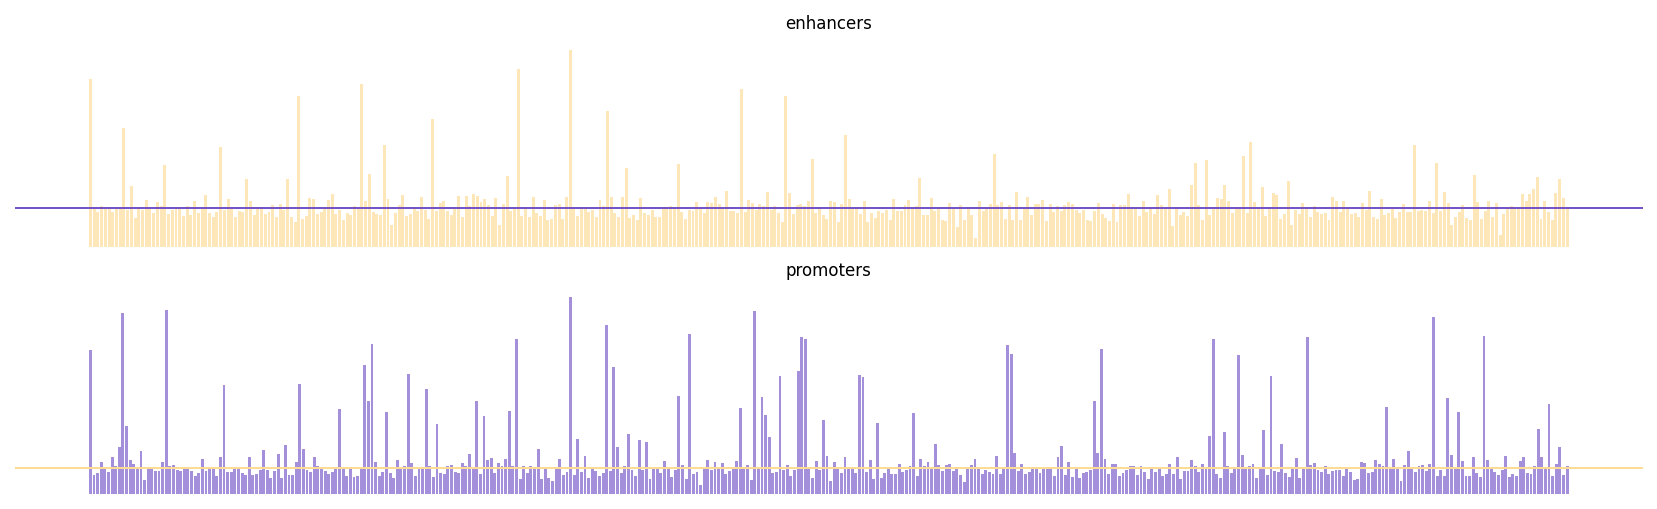

In [20]:
fig, axs = plt.subplots(2, 1,figsize=(14, 4), dpi=150)
colors = ['#fcdb94', '#7554c8']

for j, task, color in zip([0,1], data.keys(), colors):
  data[task]['mean_feature_importance'] = np.mean([data[task]['feature_selection'][i] for i in range(n_runs)], axis=0)
  data[task]['median_importance'] = np.median(data[task]['mean_feature_importance'])

  for i in range(n_runs):
    importance = data[task]['feature_selection'][i]
    axs[j].set_yscale('log')
    axs[j].bar([x for x in range(len(importance))], importance,
            alpha=0.3, color=color)
    axs[j].set_title(task, fontdict = {'fontsize':8})
    axs[j].axis("off")
    axs[j].axhline(y=data[task]['median_importance'], color=colors[(j+1)%2], linestyle='-', linewidth=0.8)
plt.show()

In [21]:
for i, task in enumerate(data.keys()):
  n_features_before = data[task]['X'].shape[1]
  a = data[task]['mean_feature_importance']
  v = data[task]['median_importance']
  mask = list(np.where(a >= v))
  mask = [data[task]['X'].columns[m] for m in mask][0]
  data[task]['X'] = data[task]['X'][mask]
  n_features_after = data[task]['X'].shape[1]
  print(
      f"{task}\n"
      f"- before #features: {n_features_before}\n"
      f"- after #features: {n_features_after}\n"
      f"- Ratio (features kept): {n_features_after/n_features_before:.2f}"
  )

enhancers
- before #features: 398
- after #features: 199
- Ratio (features kept): 0.50
promoters
- before #features: 410
- after #features: 205
- Ratio (features kept): 0.50


### Retrieving and bedding genomic sequences

After reducing the dimensionality of the feature space we can finally download the human genome for *hg38* and bed it with respect to the epigenomic data.

In [22]:
from ucsc_genomes_downloader import Genome
genome_sequence = Genome(genome)
genome_sequence

Loading chromosomes for genome hg38:   0%|                                                      | 0/25 [00:00<…

C:\Users\alice\AppData\Local\Programs\Python\Python310\lib\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


Human, Homo sapiens, hg38, 2013-12-08, 25 chromosomes

In [187]:
from keras_bed_sequence import BedSequence

def one_hot_bed_file(y:pd.DataFrame)->pd.DataFrame:
    """Return one-hot encoded bed coordinates from given dataset."""
    y = y.reset_index()[y.index.names] # get the bed indeces from labels (or epigenomic data)
     #pd.DataFrame(
    return np.array(BedSequence(
      genome_sequence, # from ucsc_genomes
      bed=y,
      batch_size=1
    ))#.reshape(-1, 4*window_size)
       #                )

for task in data.keys(): data[task]['genome'] = one_hot_bed_file(data[task]['y'])  

In [188]:
data['enhancers']['genome']

array([[[[1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         ...,
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.]]],


       [[[1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         ...,
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]]],


       [[[0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         ...,
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.]]],


       ...,


       [[[0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         ...,
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.]]],


       [[[1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         ...,
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.]]],


       [[[0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
     

In [189]:
data['enhancers']['genome'].shape

(63285, 1, 256, 4)

# Dimensionality reduction via T-SNE and UMAP

In [563]:
import umap # https://www.nature.com/articles/s41467-020-15351-4

def get_umap_decomposition(
    X: np.array,
)->pd.DataFrame:
    """Return the UMAP decomposition of the given data."""
    return pd.DataFrame(
        umap.UMAP(n_neighbors=10,
                  min_dist=0.3,
                  n_components = 2,
                  metric='cosine').fit_transform(X)
    )

for task in tqdm(data.keys(), desc='UMAP decomposition'):
  data[task]['decomposition'] = get_umap_decomposition(data[task]['X'].values)
  data[task]['genomic_decomposition'] = get_umap_decomposition(data[task]['genome'].reshape(-1, 4*window_size))

UMAP decomposition:   0%|          | 0/2 [00:00<?, ?it/s]

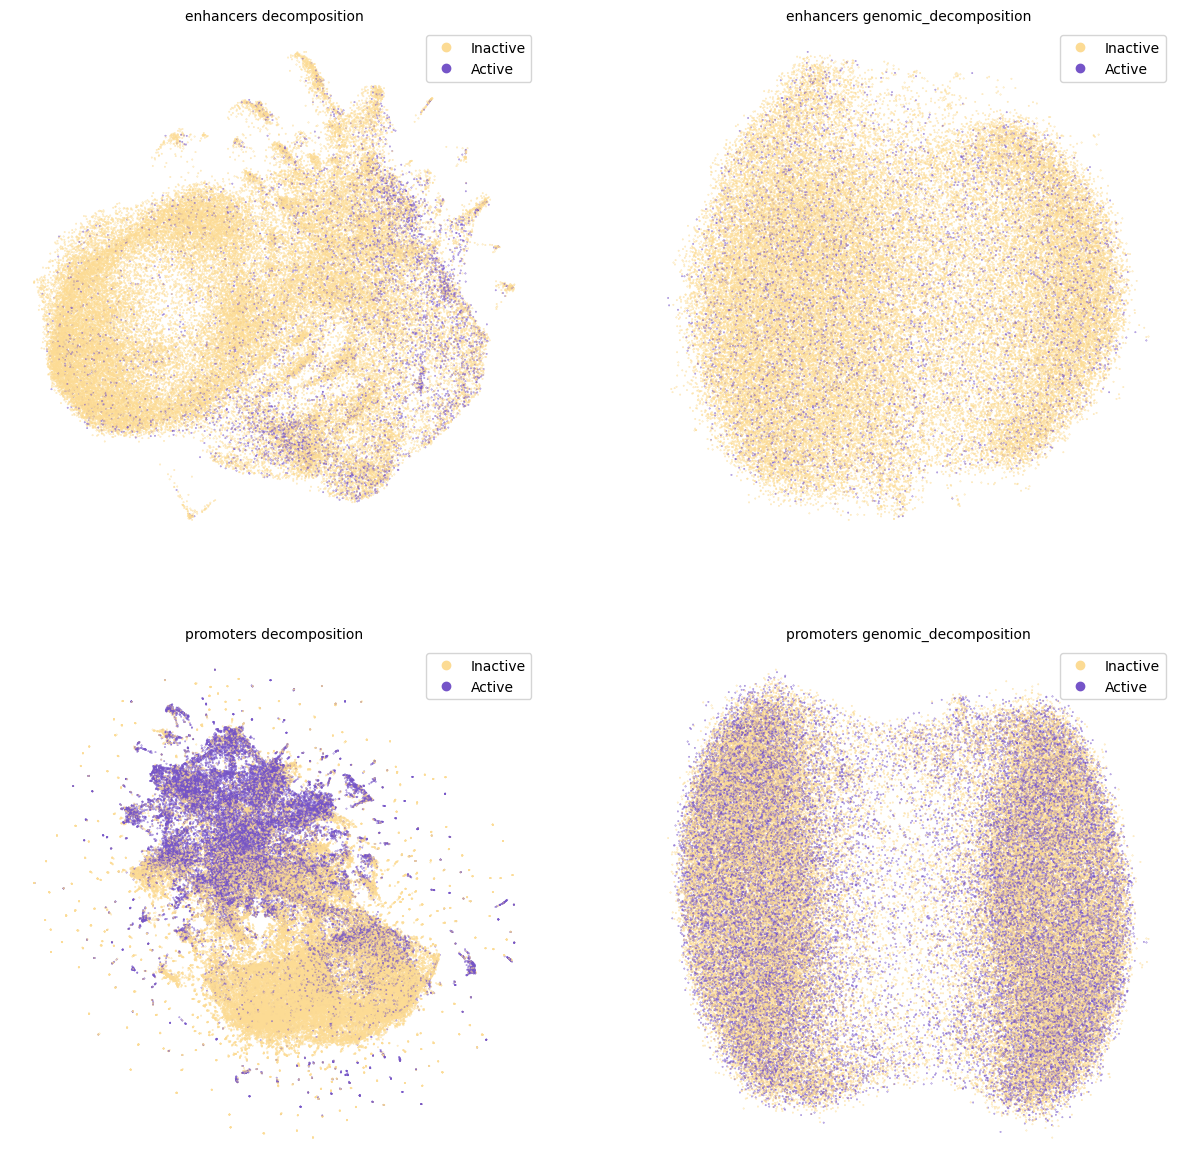

In [564]:
from matplotlib.pyplot import figure
import matplotlib as mpl

fig, axs = plt.subplots(2, 2,figsize=(15, 15), dpi=100)
for i, task, clip_value in zip([0,1], data.keys(), [0.0, 0.0]):
  for j, data_dec in enumerate(['decomposition','genomic_decomposition']):
    u = data[task][data_dec]

    cmap = mpl.colors.ListedColormap(['#fcdb94', '#7554c8'])
    
    scatter = axs[i,j].scatter(u.iloc[:,0], u.iloc[:,1],c=data[task]['binary_y'].values, cmap=cmap, s =0.08) # norm=mpl.colors.LogNorm()
    axs[i,j].axis('off')
    axs[i,j].set_title(task+' '+data_dec, fontdict = {'fontsize':10})
    axs[i,j].legend(handles=scatter.legend_elements()[0], labels=['Inactive','Active'])

plt.show()

We do the same with T-SNE, but computed after subsampling the data to compute it faster and compare it to UMAP.

In [566]:
from sklearn.manifold import TSNE

def get_tsne_decomposition(
    X: pd.DataFrame,
    y: pd.DataFrame,
    is_genome: bool = False
)->pd.DataFrame:
    """Return the 2D TSNE decomposition of the given data."""
    if is_genome:
      X = pd.DataFrame(X.reshape(-1, 4*window_size))
      y = y.reset_index(drop=True)
    
    df = X.join(y).groupby('K562').apply(lambda x: x.sample(frac=.1)).reset_index(drop=True)
    labels = df['K562']

    x_tsne = pd.DataFrame(
        TSNE(n_components=2).fit_transform(df.values),
        index=df.index
    )
    return {'X':x_tsne, 'y':labels}

for task in tqdm(data.keys(), desc='T-SNE decomposition'):
  data[task]['decomposition_TSNE'] = get_tsne_decomposition(data[task]['X'], data[task]['binary_y'])
  data[task]['genomic_decomposition_TSNE'] = get_tsne_decomposition(data[task]['genome'], data[task]['binary_y'], is_genome=True)

T-SNE decomposition:   0%|          | 0/2 [00:00<?, ?it/s]

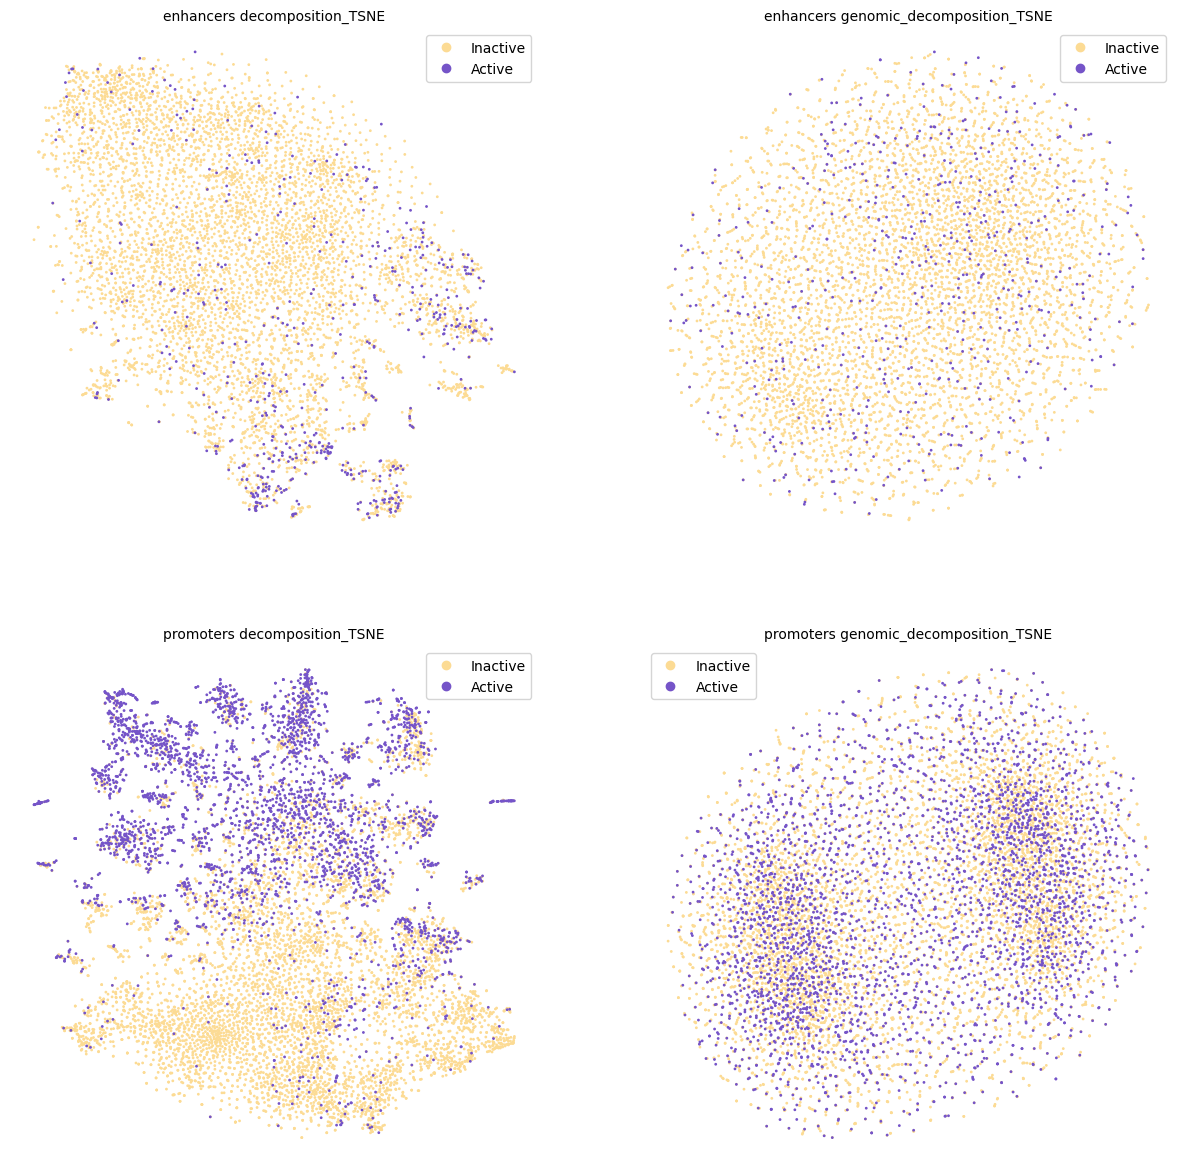

In [567]:
%%time
from matplotlib.pyplot import figure
import matplotlib as mpl

fig, axs = plt.subplots(2, 2,figsize=(15, 15), dpi=100)
for i, task, clip_value in zip([0,1], data.keys(), [0.0, 0.0]):
  for j, data_dec in enumerate(['decomposition_TSNE','genomic_decomposition_TSNE']):
    u = data[task][data_dec]['X']
    y = data[task][data_dec]['y']

    colors = {'0':'#fcdb94', '1':'#7554c8'}
    cmap = mpl.colors.ListedColormap(['#fcdb94', '#7554c8'])
    
    scatter = axs[i,j].scatter(u.iloc[:,0], u.iloc[:,1], c=y, cmap=cmap, s =1) # norm=mpl.colors.LogNorm()
    axs[i,j].axis('off')
    axs[i,j].set_title(task+' '+data_dec, fontdict = {'fontsize':10})
    axs[i,j].legend(handles=scatter.legend_elements()[0], labels=['Inactive','Active'])

plt.show()

# Build models

Data to feed the model

Import layers

In [42]:
from typing import Tuple
from keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Concatenate, Layer
from keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D, GlobalMaxPool1D, Flatten
from keras import regularizers
from keras.models import Model, clone_model
from extra_keras_metrics import get_complete_binary_metrics

### Feed Forward Neural Network

In [273]:
def build_binary_classification_ffnn(
    input_shape: int,
    n_hidden: int
)->Tuple[Model, Layer, Layer]:
    """Returns Feed-Forward Neural Network model for binary classification.
    
    Parameters
    -----------------------
    input_shape: int,
        Number of features in the input layer.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_epigenomic_data = Input(shape=(input_shape,), name="epigenomic_data")
    hidden = Dense(32, activation="relu")(input_epigenomic_data)

    for _ in range(n_hidden):
        hidden = Dense(
            8,
            activation="relu",
        )(hidden)
        hidden = Dropout(rate=0.3)(hidden)

    last_hidden_ffnn = hidden
    output_ffnn = Dense(1, activation="sigmoid")(last_hidden_ffnn)

    ffnn = Model(
        inputs=input_epigenomic_data,
        outputs=output_ffnn,
        name="BinaryClassificationFFNN"
    )

    ffnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    return ffnn, input_epigenomic_data, last_hidden_ffnn

### Convolutional Neural Network 

In [274]:
def build_binary_classification_cnn(
    window_size: int,
    n_hidden: int
)->Tuple[Model, Layer, Layer]:
    """Returns Convolutional Neural Network model for binary classification.
    
    Parameters
    -----------------------
    window_size: int,
        Size of the input genomic window.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_sequence_data = Input(shape=(window_size, 4), name="sequence_data")
    hidden = Conv1D(32, kernel_size=6, activation="relu")(input_sequence_data)

    for _ in range(n_hidden):
        hidden = Conv1D(
            8,
            kernel_size=4,
            activation="relu",
        )(hidden)
        hidden = Dropout(rate=0.3)(hidden)
        hidden = MaxPool1D(pool_size=2)(hidden)
        
    hidden = GlobalAveragePooling1D()(hidden)
    last_hidden_cnn = Dense(64, activation="relu")(hidden)
    output_cnn = Dense(1, activation="sigmoid")(last_hidden_cnn)

    cnn = Model(
        inputs=input_sequence_data,
        outputs=output_cnn,
        name="BinaryClassificationCNN"
    )

    cnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    return cnn, input_sequence_data, last_hidden_cnn

### Multi-Modal Neural Network

In [228]:
def build_binary_classification_mmnn(
    input_epigenomic_data: Layer,
    input_sequence_data: Layer,
    last_hidden_ffnn: Layer,
    last_hidden_cnn: Layer,
):
    """Returns Multi-Modal Neural Network model for binary classification.
    
    Parameters
    -----------------------
    input_epigenomic_data: Optional[Layer] = None,
        Input for the epigenomic data from a FFNN model.
    input_sequence_data: Optional[Layer] = None,
        Input for the sequence data from a CNN model.
    output_ffnn: Optional[Layer] = None,
        Feature selection layer from a FFNN model.
    last_hidden_cnn: Optional[Layer] = None,
        Feature selection layer from a CNN model.
        
    """
    concatenation_layer = Concatenate()([
            last_hidden_ffnn,
            last_hidden_cnn
        ])

    last_hidden_mmnn = Dense(64, activation="relu")(concatenation_layer)
    output_mmnn = Dense(1, activation="sigmoid")(last_hidden_mmnn)

    mmnn = Model(
        inputs=[input_epigenomic_data, input_sequence_data],
        outputs=output_mmnn,
        name="MMNN"
    )

    return mmnn

In [254]:
from keras_mixed_sequence import MixedSequence, VectorSequence
from keras_bed_sequence import BedSequence

def get_cnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a CNN model on genomic sequences.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a CNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

def get_ffnn_sequence(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a FFNN model on epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a FFNN.
    """
    return MixedSequence(
        x={
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

def get_mmnn_sequence(
  genome: Genome,
  bed: pd.DataFrame,
  X: np.ndarray,
  y: np.ndarray,
  batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a MMNN model on both genomic sequences and epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a MMNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            ),
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

In [287]:
def get_sequence_by_model_name(model_name, X, y, genome_seq):
  if model_name == "Binary classification MMNN":
    # Build MixedSequence object for MMNN
    sequence = get_mmnn_sequence(
      genome = genome_seq,
      bed = y.reset_index(),
      X = X.values.astype(float),
      y = y.values.astype(float).flatten(),
      batch_size = X.shape[1]
    )
  elif model_name == "Binary classification CNN":
    sequence = get_cnn_sequence(
      genome = genome_seq,
      bed = y.reset_index(),
      y = y.values.astype(float).flatten()
    )
  elif model_name == "Binary classification FFNN":
    sequence = get_ffnn_sequence(
      X = X.values.astype(float),
      y = y.values.astype(float).flatten()
    )
  else: raise ValueError("Wrong model name!")
  return sequence

# Training

In [47]:
for task in data.keys(): print(data[task]['X'].shape, data[task]['genome'].shape, data[task]['y'].shape)

(63285, 199) (63285, 1, 256, 4) (63285, 1)
(99881, 205) (99881, 1, 256, 4) (99881, 1)


Train models

In [312]:
from keras.callbacks import EarlyStopping
from keras_tqdm import TQDMNotebookCallback
from sklearn.model_selection import StratifiedShuffleSplit
from epigenomic_dataset.utils import normalize_epigenomic_data

def train_model_with_holdout(
    model: Model,
    model_name: str,
    task: str,
    X: pd.DataFrame,
    y: pd.DataFrame,
    number_of_splits: int = 2,
    epochs: int = 10,
    genome_seq = None
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """ Returns training history and model evaluations as pd.Dataframe.
    
    Parameters
    ---------------------
    model: Model,
        The model to train.
    model_name : str,
        The model name.
    task: str,
        The name of the task.
    training_sequence: MixedSequence,
        The training sequence.
    test_sequence: MixedSequence,
        The test sequence.
    number_of_splits: int,
        The number of holdouts.
    """

    def train(model_copy:Model, holdout_number:int,
              train_X, val_X,
              testing_data):
        callbacks = [
                EarlyStopping(
                    "loss",
                    min_delta=0.001,
                    patience=2,
                    mode="min"
                ),
                #TQDMNotebookCallback() # how the model is performing during the training.
            ]

        model_copy.compile(
            optimizer="nadam",
            loss="binary_crossentropy",
            metrics=get_complete_binary_metrics()
        )
        validation_data = val_X
        
        history = pd.DataFrame(model_copy.fit(
            x= train_X, 
            y= None,
            validation_data = validation_data,
            epochs=epochs,
            verbose=False,
            #callbacks=callbacks
        ).history)
        
        evaluations = model_copy.evaluate(testing_data, verbose=False)
        predictions = model_copy.predict(testing_data, verbose=False)

        return history, evaluations, predictions
    
    model_history = {}
    model_evaluations = {'evaluations':[],'predictions':[]}
    testing_data = {'X':[],'y':[]} # no training will be made on this data

    testing_data_generator = StratifiedShuffleSplit(
        n_splits=1,
        test_size=0.2
    )
    
    for train_index, test_index in testing_data_generator.split(X, y):
      X, testing_data['X'] = X.iloc[train_index], X.iloc[test_index]
      y, testing_data['y'] = y.iloc[train_index], y.iloc[test_index]
        
    testing_data = get_sequence_by_model_name(model_name,
                            testing_data['X'], testing_data['y'], genome_seq)

    holdouts_generator = StratifiedShuffleSplit(
        n_splits=number_of_splits,
        test_size=0.2
    )
    
    for holdout_number, (train_indices, val_indices) in tqdm(
      enumerate(holdouts_generator.split(X, y)),
        total=number_of_splits,
        leave=False,
        desc=f"Training holdouts for {task}"
      ):

      # Copy model to get same architecture but train new weights on new inputs
      model_copy = clone_model(model)

      # Get the training and test data
      train_X, val_X = X.iloc[train_indices], X.iloc[val_indices]
      train_y, val_y = y.iloc[train_indices], y.iloc[val_indices]
      # Impute and normalize the epigenomic data
      #train_X, test_X = normalize_epigenomic_data(train_X, test_X)

      train_X = get_sequence_by_model_name(model_name, val_X, val_y, genome_seq)
      val_X = get_sequence_by_model_name(model_name, val_X, val_y, genome_seq)

      history, evaluations, predictions = train(model_copy, holdout_number, 
                                    train_X, val_X,
                                    testing_data)
      
      model_history[holdout_number] = {
          'model': model_copy, # store trained model
          'history' : history
      }
      
      model_evaluations['predictions'].append(predictions)
      model_evaluations['evaluations'].append(evaluations)
    
    model_evaluations['evaluations'] = pd.DataFrame(model_evaluations['evaluations'],
                                                   columns=model_history[0]['history'].columns[:27])
    return model_history, model_evaluations

In [348]:
number_of_holdouts = 3
epochs = 10
n_hidden = 1

In [349]:
ffnn_model_name = "Binary classification FFNN"

for task in data.keys():

  X, y = data[task]['X'], data[task]['binary_y']
  number_of_features = X.shape[1]
  ffnn_model, input_epigenomic_data, last_hidden_ffnn = build_binary_classification_ffnn(input_shape=number_of_features, n_hidden=2)
  #'''
  history, evaluations = train_model_with_holdout(ffnn_model, ffnn_model_name, task, 
                                                  X, y, number_of_splits=number_of_holdouts, epochs=epochs,
                                                  genome_seq = genome_sequence) 
  
  data[task]['training_history'].update( {ffnn_model_name : history} )
  data[task]['evaluation'].update( {ffnn_model_name : evaluations} )
  #'''

Training holdouts for enhancers:   0%|          | 0/3 [00:00<?, ?it/s]

Training holdouts for promoters:   0%|          | 0/3 [00:00<?, ?it/s]

In [350]:
ffnn_model.summary()

Model: "BinaryClassificationFFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 epigenomic_data (InputLayer  [(None, 205)]            0         
 )                                                               
                                                                 
 dense (Dense)               (None, 32)                6592      
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                          

In [351]:
cnn_model_name = "Binary classification CNN"

for task in data.keys():
  X, y = data[task]['X'], data[task]['binary_y']
  cnn_model, input_sequence_data, last_hidden_cnn = build_binary_classification_cnn(window_size=window_size, n_hidden=n_hidden)
  #'''
  history, evaluations = train_model_with_holdout(cnn_model, cnn_model_name, 
                                                 task, X, y, number_of_splits=number_of_holdouts, epochs=epochs,
                                                 genome_seq = genome_sequence) 

  data[task]['training_history'].update( {cnn_model_name : history} )
  data[task]['evaluation'].update( {cnn_model_name : evaluations} )
  #'''

Training holdouts for enhancers:   0%|          | 0/3 [00:00<?, ?it/s]

Training holdouts for promoters:   0%|          | 0/3 [00:00<?, ?it/s]

In [352]:
cnn_model.summary()

Model: "BinaryClassificationCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequence_data (InputLayer)  [(None, 256, 4)]          0         
                                                                 
 conv1d (Conv1D)             (None, 251, 32)           800       
                                                                 
 conv1d_1 (Conv1D)           (None, 248, 8)            1032      
                                                                 
 dropout (Dropout)           (None, 248, 8)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 124, 8)           0         
 )                                                               
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                    

In [354]:
mmnn_model_name = "Binary classification MMNN"

for task in data.keys():
  X, y = data[task]['X'], data[task]['binary_y']
  number_of_features = X.shape[1]
    
  _, input_epigenomic_data, last_hidden_ffnn = build_binary_classification_ffnn(input_shape=number_of_features, n_hidden=n_hidden)
  _, input_sequence_data, last_hidden_cnn = build_binary_classification_cnn(window_size=window_size, n_hidden=n_hidden)

  mmnn_model = build_binary_classification_mmnn(
    input_sequence_data=input_sequence_data,
    input_epigenomic_data=input_epigenomic_data,
    last_hidden_ffnn=last_hidden_ffnn,
    last_hidden_cnn=last_hidden_cnn
  )

  history, evaluations = train_model_with_holdout(mmnn_model, mmnn_model_name, 
                                                  task, X, y, number_of_splits=number_of_holdouts, epochs=epochs,
                                                  genome_seq = genome_sequence)

  data[task]['training_history'].update( {mmnn_model_name : history} )
  data[task]['evaluation'].update( {mmnn_model_name : evaluations} )

Training holdouts for enhancers:   0%|          | 0/3 [00:00<?, ?it/s]

Training holdouts for promoters:   0%|          | 0/3 [00:00<?, ?it/s]

In [355]:
mmnn_model.summary()

Model: "MMNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence_data (InputLayer)     [(None, 256, 4)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 251, 32)      800         ['sequence_data[0][0]']          
                                                                                                  
 conv1d_1 (Conv1D)              (None, 248, 8)       1032        ['conv1d[0][0]']                 
                                                                                                  
 epigenomic_data (InputLayer)   [(None, 205)]        0           []                               
                                                                                               

# Evaluation

In [356]:
for task in data.keys():
  for i, model_history in enumerate(data[task]['training_history'].keys()):
    print(f"Task: {task} - Model: {model_history}")
    for j, holdout in enumerate(data[task]['training_history'][model_history].values()):
      print(f"Training History of Holdout#{j}")
      #print(holdout['model'])
      display(holdout['history'])

Task: enhancers - Model: Binary classification FFNN
Training History of Holdout#0


,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,val_false_discovery_rate,val_false_omission_rate,val_prevalence_threshold,val_threat_score,val_fowlkes_mallows_index,val_informedness,val_markedness,val_positive_likelyhood_ratio,val_negative_likelyhood_ratio,val_DOR
0,1.508474,0.149714,0.908371,0.086048,0.570463,0.145646,0.157204,0.492759,0.077148,0.091629,...,0.914040,0.146018,0.502120,0.085674,0.491776,0.287664,-0.060058,0.983202,1.787591,0.967637
1,1.092269,0.225953,0.761312,0.081084,0.509461,0.109416,0.146559,0.468029,0.174746,0.238688,...,0.919555,0.132830,0.511156,0.078868,0.462614,0.253829,-0.052385,0.914613,1.601423,0.860861
2,0.898428,0.322042,0.573529,0.072480,0.451679,0.088639,0.128697,0.435758,0.297987,0.426471,...,0.925743,0.117474,0.521987,0.070669,0.442856,0.210002,-0.043216,0.838616,1.391640,0.794867
3,0.803205,0.436599,0.436652,0.069015,0.448160,0.085749,0.119191,0.436623,0.436594,0.563348,...,0.931517,0.108454,0.532850,0.062457,0.437508,0.168616,-0.039971,0.768608,1.271789,0.777802
4,0.756413,0.527750,0.315611,0.062612,0.446695,0.084694,0.104494,0.431826,0.548042,0.684389,...,0.929652,0.097342,0.529255,0.060420,0.460426,0.145218,-0.026995,0.791122,1.127437,0.853313
5,0.726130,0.605175,0.235294,0.058924,0.447147,0.077824,0.094246,0.437924,0.640554,0.764706,...,0.930874,0.093498,0.531601,0.054252,0.470999,0.117979,-0.024371,0.776364,1.078313,0.890356
6,0.700983,0.669070,0.182127,0.057727,0.462237,0.080250,0.087667,0.448886,0.715646,0.817873,...,0.929770,0.090525,0.529481,0.047479,0.482979,0.094749,-0.020295,0.789697,1.040616,0.934158
7,0.684546,0.726644,0.133484,0.055660,0.468874,0.079629,0.078562,0.458432,0.783380,0.866516,...,0.923541,0.088480,0.518048,0.042175,0.493322,0.081076,-0.012021,0.865534,1.014829,0.973639
8,0.663918,0.770591,0.119910,0.064204,0.505468,0.085002,0.083629,0.476369,0.832828,0.880090,...,0.915721,0.087496,0.504841,0.035887,0.498845,0.070410,-0.003217,0.962206,1.002461,0.995390
9,0.648716,0.798440,0.078054,0.053282,0.498994,0.083868,0.063332,0.472700,0.867345,0.921946,...,0.902965,0.086930,0.485436,0.029532,0.502238,0.062862,0.010105,1.123492,0.995355,1.008993


Training History of Holdout#1


,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,val_false_discovery_rate,val_false_omission_rate,val_prevalence_threshold,val_threat_score,val_fowlkes_mallows_index,val_informedness,val_markedness,val_positive_likelyhood_ratio,val_negative_likelyhood_ratio,val_DOR
0,1.185816,0.368359,0.559955,0.076130,0.469479,0.111763,0.134037,0.454994,0.350032,0.440045,...,0.936626,0.119262,0.543164,0.058180,0.414136,0.162205,-0.055888,0.707392,1.415690,0.706881
1,0.876029,0.531701,0.334842,0.066517,0.419747,0.086947,0.110986,0.442686,0.550530,0.665158,...,0.927419,0.094176,0.525062,0.060403,0.470591,0.138609,-0.021595,0.818198,1.086946,0.888900
2,0.703107,0.670946,0.303167,0.089812,0.489069,0.101384,0.138573,0.504646,0.706124,0.696833,...,0.909910,0.086794,0.495674,0.060923,0.502687,0.119447,0.003296,1.035123,0.993655,1.010806
3,0.600137,0.752518,0.176471,0.080662,0.511230,0.095006,0.110717,0.492044,0.807617,0.823529,...,0.885635,0.085238,0.462549,0.053983,0.512026,0.102998,0.029128,1.350060,0.974173,1.049290
4,0.550522,0.800316,0.125566,0.081618,0.543825,0.097504,0.098930,0.495211,0.864856,0.874434,...,0.869444,0.085706,0.443860,0.039265,0.509650,0.083314,0.044850,1.569878,0.980023,1.039360
5,0.500351,0.824610,0.102941,0.084730,0.566295,0.099757,0.092952,0.498289,0.893638,0.897059,...,0.819095,0.085424,0.396895,0.034384,0.511544,0.085832,0.095481,2.309012,0.976498,1.047265
6,0.464275,0.852360,0.091629,0.104787,0.582945,0.110955,0.097767,0.508377,0.925124,0.908371,...,0.774775,0.085771,0.364519,0.025773,0.509488,0.079809,0.139454,3.039140,0.980846,1.038684
7,0.444385,0.857496,0.080317,0.101284,0.601168,0.117010,0.089590,0.506075,0.931833,0.919683,...,0.701493,0.085893,0.321621,0.021482,0.508770,0.082180,0.212614,4.448743,0.982371,1.035704
8,0.414955,0.867667,0.064480,0.100000,0.623441,0.121626,0.078404,0.504486,0.944493,0.935520,...,0.607843,0.085757,0.277999,0.021858,0.509635,0.094193,0.306400,6.744800,0.980665,1.039297
9,0.401878,0.872704,0.062217,0.106796,0.634040,0.125873,0.078628,0.506222,0.950227,0.937783,...,0.560976,0.085870,0.259036,0.019846,0.508937,0.094548,0.353154,8.181651,0.982082,1.036397


Training History of Holdout#2


,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,val_false_discovery_rate,val_false_omission_rate,val_prevalence_threshold,val_threat_score,val_fowlkes_mallows_index,val_informedness,val_markedness,val_positive_likelyhood_ratio,val_negative_likelyhood_ratio,val_DOR
0,0.655410,0.731681,0.227376,0.089933,0.473900,0.092030,0.128887,0.503647,0.779918,0.772624,...,0.941718,0.088265,0.554210,0.015953,0.494138,0.035393,-0.029983,0.647035,1.012127,0.976822
1,0.570103,0.816808,0.105204,0.080380,0.479805,0.088887,0.091132,0.495039,0.884873,0.894796,...,0.939759,0.087524,0.549887,0.005198,0.498608,0.018459,-0.027283,0.670168,1.002807,0.994448
2,0.520818,0.854730,0.064480,0.081312,0.493507,0.087878,0.071924,0.497399,0.930318,0.935520,...,1.000000,0.087481,1.000052,0.000000,0.498864,0.000000,-0.087481,0.000000,1.002277,0.995466
3,0.492644,0.871124,0.031674,0.058700,0.495122,0.085521,0.041146,0.491546,0.951417,0.968326,...,1.000000,0.087386,1.000110,0.000000,0.499459,0.000000,-0.087386,0.000000,1.001083,0.997838
4,0.455985,0.882382,0.041855,0.097113,0.533309,0.093052,0.058498,0.502317,0.962779,0.958145,...,1.000000,0.087326,1.000367,0.000000,0.499838,0.000000,-0.087326,0.000000,1.000325,0.999351
5,0.426955,0.892060,0.027149,0.093385,0.539088,0.095072,0.042068,0.500969,0.974789,0.972851,...,0.000000,0.087300,0.000000,0.000000,0.500000,0.000000,-0.087300,0.000000,1.000000,1.000000
6,0.401399,0.893640,0.032805,0.115538,0.573643,0.106478,0.051101,0.504392,0.975979,0.967195,...,0.000000,0.087300,0.000000,0.000000,0.500000,0.000000,-0.087300,0.000000,1.000000,1.000000
7,0.378695,0.897195,0.016968,0.080214,0.607711,0.113288,0.028011,0.499179,0.981389,0.983032,...,0.000000,0.087300,0.000000,0.000000,0.500000,0.000000,-0.087300,0.000000,1.000000,1.000000
8,0.369589,0.898084,0.015837,0.079545,0.632691,0.124387,0.026415,0.499154,0.982471,0.984163,...,0.000000,0.087300,0.000000,0.000000,0.500000,0.000000,-0.087300,0.000000,1.000000,1.000000
9,0.353890,0.902627,0.005656,0.044643,0.651144,0.132396,0.010040,0.497039,0.988422,0.994344,...,0.000000,0.087300,0.000000,0.000000,0.500000,0.000000,-0.087300,0.000000,1.000000,1.000000


Task: enhancers - Model: Binary classification CNN
Training History of Holdout#0


,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,val_false_discovery_rate,val_false_omission_rate,val_prevalence_threshold,val_threat_score,val_fowlkes_mallows_index,val_informedness,val_markedness,val_positive_likelyhood_ratio,val_negative_likelyhood_ratio,val_DOR
0,0.643206,0.9127,0.0,0.0,0.485320,0.083807,0.0,0.5,1.0,1.0,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
1,0.524790,0.9127,0.0,0.0,0.504214,0.087688,0.0,0.5,1.0,1.0,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
2,0.356506,0.9127,0.0,0.0,0.497810,0.087921,0.0,0.5,1.0,1.0,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
3,0.297998,0.9127,0.0,0.0,0.501821,0.086283,0.0,0.5,1.0,1.0,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
4,0.297528,0.9127,0.0,0.0,0.498650,0.090874,0.0,0.5,1.0,1.0,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
5,0.296643,0.9127,0.0,0.0,0.505500,0.090551,0.0,0.5,1.0,1.0,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
6,0.296502,0.9127,0.0,0.0,0.503281,0.092399,0.0,0.5,1.0,1.0,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
7,0.296393,0.9127,0.0,0.0,0.510728,0.094319,0.0,0.5,1.0,1.0,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
8,0.296265,0.9127,0.0,0.0,0.511260,0.095892,0.0,0.5,1.0,1.0,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
9,0.296086,0.9127,0.0,0.0,0.519281,0.099097,0.0,0.5,1.0,1.0,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0


Training History of Holdout#1


,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,val_false_discovery_rate,val_false_omission_rate,val_prevalence_threshold,val_threat_score,val_fowlkes_mallows_index,val_informedness,val_markedness,val_positive_likelyhood_ratio,val_negative_likelyhood_ratio,val_DOR
0,0.673661,0.743532,0.219457,0.092337,0.505419,0.087684,0.129983,0.506558,0.793659,0.780543,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
1,0.584398,0.912700,0.000000,0.000000,0.491635,0.083919,0.000000,0.500000,1.000000,1.000000,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
2,0.438074,0.912700,0.000000,0.000000,0.512174,0.090035,0.000000,0.500000,1.000000,1.000000,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
3,0.314508,0.912700,0.000000,0.000000,0.505725,0.088521,0.000000,0.500000,1.000000,1.000000,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
4,0.296113,0.912700,0.000000,0.000000,0.529562,0.094427,0.000000,0.500000,1.000000,1.000000,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
5,0.296432,0.912700,0.000000,0.000000,0.508072,0.089042,0.000000,0.500000,1.000000,1.000000,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
6,0.295992,0.912700,0.000000,0.000000,0.520823,0.096168,0.000000,0.500000,1.000000,1.000000,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
7,0.296036,0.912700,0.000000,0.000000,0.520327,0.095790,0.000000,0.500000,1.000000,1.000000,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
8,0.296138,0.912700,0.000000,0.000000,0.515582,0.097348,0.000000,0.500000,1.000000,1.000000,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
9,0.295868,0.912700,0.000000,0.000000,0.520487,0.099664,0.000000,0.500000,1.000000,1.000000,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0


Training History of Holdout#2


,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,val_false_discovery_rate,val_false_omission_rate,val_prevalence_threshold,val_threat_score,val_fowlkes_mallows_index,val_informedness,val_markedness,val_positive_likelyhood_ratio,val_negative_likelyhood_ratio,val_DOR
0,0.678707,0.71114,0.242081,0.086675,0.496179,0.086198,0.127647,0.499043,0.756005,0.757919,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
1,0.582705,0.91270,0.000000,0.000000,0.491559,0.084007,0.000000,0.500000,1.000000,1.000000,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
2,0.375190,0.91270,0.000000,0.000000,0.499047,0.086809,0.000000,0.500000,1.000000,1.000000,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
3,0.298155,0.91270,0.000000,0.000000,0.491631,0.086154,0.000000,0.500000,1.000000,1.000000,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
4,0.297225,0.91270,0.000000,0.000000,0.488724,0.086109,0.000000,0.500000,1.000000,1.000000,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
5,0.296646,0.91270,0.000000,0.000000,0.488035,0.088787,0.000000,0.500000,1.000000,1.000000,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
6,0.296585,0.91270,0.000000,0.000000,0.484342,0.084917,0.000000,0.500000,1.000000,1.000000,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
7,0.296267,0.91270,0.000000,0.000000,0.510096,0.093272,0.000000,0.500000,1.000000,1.000000,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
8,0.296213,0.91270,0.000000,0.000000,0.509979,0.094369,0.000000,0.500000,1.000000,1.000000,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0
9,0.296330,0.91270,0.000000,0.000000,0.500641,0.088813,0.000000,0.500000,1.000000,1.000000,...,0.0,0.0873,0.0,0.0,0.5,0.0,-0.0873,0.0,1.0,1.0


Task: enhancers - Model: Binary classification MMNN
Training History of Holdout#0


,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,val_false_discovery_rate,val_false_omission_rate,val_prevalence_threshold,val_threat_score,val_fowlkes_mallows_index,val_informedness,val_markedness,val_positive_likelyhood_ratio,val_negative_likelyhood_ratio,val_DOR
0,0.402022,0.846632,0.114253,0.115959,0.534625,0.102396,0.115100,0.515469,0.916685,0.885747,...,0.442857,0.084029,0.216138,0.042623,0.520382,0.156780,0.473113,13.152360,0.959099,1.084991
1,0.277594,0.912700,0.038462,0.500000,0.690433,0.211529,0.071429,0.517391,0.996321,0.961538,...,0.388889,0.081653,0.197892,0.071274,0.535058,0.213602,0.529458,16.428534,0.929564,1.150806
2,0.264683,0.912799,0.050905,0.505618,0.743365,0.259430,0.092497,0.523072,0.995239,0.949095,...,0.200000,0.085536,0.133929,0.022497,0.511042,0.134535,0.714464,41.811279,0.977904,1.045164
3,0.256740,0.913984,0.055430,0.576471,0.759660,0.288908,0.101135,0.525767,0.996105,0.944570,...,0.227273,0.085808,0.143637,0.019123,0.509345,0.121902,0.686920,35.539585,0.981300,1.038091
4,0.252809,0.913194,0.048643,0.530864,0.778925,0.285298,0.089119,0.522265,0.995888,0.951357,...,0.339450,0.081062,0.181472,0.078176,0.538722,0.231949,0.579488,20.343872,0.922244,1.167891
5,0.249914,0.914873,0.075792,0.598214,0.784197,0.311664,0.134538,0.535461,0.995131,0.924208,...,0.192308,0.085446,0.131124,0.023622,0.511607,0.138518,0.722247,43.901840,0.976773,1.047533
6,0.246636,0.913786,0.054299,0.564706,0.792861,0.317635,0.099071,0.525148,0.995997,0.945701,...,0.294118,0.082064,0.166413,0.066007,0.532584,0.218885,0.623819,25.090477,0.934655,1.139422
7,0.241921,0.915564,0.083710,0.621849,0.805778,0.334414,0.147557,0.539421,0.995131,0.916290,...,0.366667,0.079090,0.190495,0.101171,0.550757,0.260887,0.554244,18.057901,0.897877,1.225969
8,0.240919,0.914576,0.076923,0.581197,0.814047,0.336341,0.135864,0.535811,0.994698,0.923077,...,0.234375,0.082985,0.146114,0.054505,0.526903,0.206006,0.682640,34.150085,0.946106,1.113733
9,0.232475,0.915959,0.105204,0.607843,0.830268,0.365071,0.179364,0.549356,0.993508,0.894796,...,0.250000,0.081490,0.151506,0.072848,0.536140,0.236634,0.668510,31.362938,0.927547,1.155823


Training History of Holdout#1


,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,val_false_discovery_rate,val_false_omission_rate,val_prevalence_threshold,val_threat_score,val_fowlkes_mallows_index,val_informedness,val_markedness,val_positive_likelyhood_ratio,val_negative_likelyhood_ratio,val_DOR
0,0.392048,0.869247,0.078054,0.119377,0.531130,0.097663,0.094391,0.511490,0.944925,0.921946,...,0.526316,0.085845,0.245851,0.019912,0.509099,0.098210,0.387840,9.408842,0.981762,1.037071
1,0.274996,0.913490,0.038462,0.566667,0.692041,0.215300,0.072034,0.517824,0.997187,0.961538,...,0.295455,0.084606,0.166859,0.034560,0.516831,0.157184,0.619939,24.928791,0.966291,1.069667
2,0.263697,0.914478,0.056561,0.609756,0.736912,0.267930,0.103520,0.526549,0.996538,0.943439,...,0.243243,0.084845,0.149183,0.031355,0.515350,0.154821,0.671912,32.522552,0.969270,1.063345
3,0.262414,0.914774,0.047511,0.666667,0.751479,0.257847,0.088701,0.522620,0.997728,0.952489,...,0.250000,0.086776,0.151509,0.006772,0.503285,0.071348,0.663224,31.349766,0.993428,1.013229
4,0.254774,0.913885,0.047511,0.583333,0.773625,0.278927,0.087866,0.522133,0.996754,0.952489,...,0.254902,0.083970,0.153183,0.042363,0.520790,0.178967,0.661128,30.557871,0.958361,1.086767
5,0.252126,0.913984,0.050905,0.584416,0.783434,0.287928,0.093652,0.523721,0.996538,0.949095,...,0.298507,0.083209,0.167878,0.051991,0.525502,0.193123,0.618284,24.567532,0.948886,1.107489
6,0.245083,0.914774,0.062217,0.617977,0.802796,0.312395,0.113052,0.529269,0.996321,0.937783,...,0.228070,0.083424,0.143914,0.049052,0.524184,0.196015,0.688505,35.382797,0.951565,1.101651
7,0.245424,0.914379,0.050905,0.616438,0.803714,0.307169,0.094044,0.523938,0.996970,0.949095,...,0.181818,0.083309,0.127241,0.050336,0.524911,0.204082,0.734873,47.042034,0.950123,1.104871
8,0.236975,0.914873,0.066742,0.614583,0.823756,0.329962,0.120408,0.531369,0.995997,0.933258,...,0.246377,0.082728,0.150261,0.057714,0.528492,0.210549,0.670895,31.977501,0.942911,1.120855
9,0.233893,0.915169,0.062217,0.647059,0.830543,0.341404,0.113519,0.529486,0.996754,0.937783,...,0.253012,0.081848,0.152538,0.068508,0.533932,0.228890,0.665140,30.865053,0.931982,1.145608


Training History of Holdout#2


,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,val_false_discovery_rate,val_false_omission_rate,val_prevalence_threshold,val_threat_score,val_fowlkes_mallows_index,val_informedness,val_markedness,val_positive_likelyhood_ratio,val_negative_likelyhood_ratio,val_DOR
0,0.375897,0.894529,0.030543,0.113445,0.517291,0.091805,0.048128,0.503856,0.977169,0.969457,...,0.539683,0.084965,0.250865,0.031590,0.514563,0.122886,0.375353,8.917047,0.970766,1.060001
1,0.277721,0.911811,0.029412,0.426230,0.687051,0.205990,0.055026,0.512812,0.996213,0.970588,...,0.250000,0.084936,0.151506,0.030235,0.514785,0.151351,0.665064,31.361032,0.970402,1.060940
2,0.265103,0.913194,0.050905,0.529412,0.739987,0.259226,0.092879,0.523288,0.995672,0.949095,...,0.354167,0.084640,0.186346,0.034406,0.516614,0.150493,0.561194,19.063511,0.966710,1.068741
3,0.260631,0.914576,0.047511,0.646154,0.751930,0.269651,0.088514,0.522511,0.997511,0.952489,...,0.385542,0.082943,0.196774,0.055677,0.527115,0.188280,0.531515,16.661779,0.945582,1.114679
4,0.255927,0.913293,0.044118,0.541667,0.768606,0.279202,0.081590,0.520274,0.996429,0.955882,...,0.250000,0.083615,0.151507,0.046771,0.522998,0.188768,0.666385,31.362183,0.953934,1.096428
5,0.251552,0.914181,0.054299,0.592593,0.780939,0.296030,0.099482,0.525364,0.996429,0.945701,...,0.333333,0.082977,0.179446,0.055006,0.526928,0.194184,0.583690,20.908730,0.945998,1.113843
6,0.248951,0.914873,0.062217,0.625000,0.787035,0.307217,0.113169,0.529323,0.996429,0.937783,...,0.235294,0.083871,0.146433,0.043527,0.521410,0.183676,0.680835,33.975327,0.957125,1.089469
7,0.243924,0.914478,0.066742,0.590000,0.801924,0.323619,0.119919,0.531153,0.995564,0.933258,...,0.255814,0.084499,0.153496,0.035754,0.517504,0.164131,0.659687,30.411266,0.964949,1.072558
8,0.239811,0.914576,0.083710,0.573643,0.812925,0.333111,0.146101,0.538880,0.994049,0.916290,...,0.000000,0.086488,0.000000,0.010181,0.505090,0.100901,0.913512,101809.953125,0.989819,1.020571
9,0.238238,0.915070,0.072398,0.615385,0.815498,0.341581,0.129555,0.534035,0.995672,0.927602,...,0.147059,0.084721,0.113806,0.032621,0.516132,0.167276,0.768221,60.626354,0.967718,1.066680


Task: promoters - Model: Binary classification FFNN
Training History of Holdout#0


,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,val_false_discovery_rate,val_false_omission_rate,val_prevalence_threshold,val_threat_score,val_fowlkes_mallows_index,val_informedness,val_markedness,val_positive_likelyhood_ratio,val_negative_likelyhood_ratio,val_DOR
0,0.760451,0.495088,0.642564,0.359204,0.613440,0.504504,0.460809,0.531551,0.420537,0.357436,...,0.584764,0.162925,0.457624,0.386302,0.622039,0.593112,0.252311,1.404698,0.385027,1.645772
1,0.682992,0.647081,0.553485,0.477953,0.675660,0.569143,0.512953,0.623940,0.694395,0.446515,...,0.424518,0.119600,0.379136,0.508097,0.754824,0.683886,0.455882,2.681663,0.268733,3.078701
2,0.653662,0.730555,0.570444,0.604702,0.742627,0.645139,0.587073,0.690968,0.811493,0.429556,...,0.333011,0.125435,0.334391,0.556976,0.788400,0.717355,0.541554,3.962132,0.283723,3.725897
3,0.615534,0.756336,0.565412,0.660139,0.777400,0.685330,0.609115,0.709131,0.852850,0.434588,...,0.277679,0.127252,0.305956,0.584453,0.803665,0.737903,0.595070,5.145851,0.288432,4.093328
4,0.564363,0.757525,0.565785,0.662737,0.799513,0.685853,0.610435,0.710118,0.854451,0.434215,...,0.248981,0.138160,0.290466,0.582042,0.800170,0.735962,0.612858,5.966962,0.317122,4.004263
5,0.535169,0.766535,0.550876,0.691139,0.815048,0.692797,0.613087,0.713215,0.875553,0.449124,...,0.228869,0.143373,0.279197,0.582241,0.799135,0.736737,0.627758,6.665156,0.331088,3.978479
6,0.508914,0.775233,0.563921,0.707340,0.826755,0.711973,0.627540,0.722987,0.882054,0.436079,...,0.228697,0.136828,0.279099,0.593520,0.806158,0.745353,0.634475,6.671659,0.313578,4.158832
7,0.499523,0.773293,0.562803,0.702816,0.832139,0.720882,0.625065,0.721251,0.879699,0.437197,...,0.231478,0.132825,0.280681,0.598900,0.809727,0.749379,0.635697,6.567739,0.302999,4.255608
8,0.486263,0.775233,0.574357,0.702050,0.836598,0.727786,0.631816,0.725568,0.876778,0.425643,...,0.226925,0.130631,0.278087,0.604690,0.813047,0.753892,0.642444,6.739185,0.297242,4.348931
9,0.479564,0.782179,0.586098,0.713961,0.843222,0.737115,0.643742,0.733699,0.881300,0.413902,...,0.220967,0.131230,0.274659,0.606542,0.813768,0.755447,0.647803,6.974244,0.298812,4.369637


Training History of Holdout#1


,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,val_false_discovery_rate,val_false_omission_rate,val_prevalence_threshold,val_threat_score,val_fowlkes_mallows_index,val_informedness,val_markedness,val_positive_likelyhood_ratio,val_negative_likelyhood_ratio,val_DOR
0,1.020772,0.468869,0.809355,0.367801,0.661965,0.539612,0.505765,0.553053,0.296750,0.190645,...,0.509373,0.121212,0.420104,0.451159,0.701635,0.645278,0.369415,1.905394,0.272855,2.351596
1,0.737550,0.596145,0.686731,0.435682,0.690786,0.551861,0.533131,0.618542,0.550353,0.313269,...,0.365605,0.132843,0.350543,0.530660,0.770870,0.696390,0.501552,3.432554,0.303047,3.364325
2,0.624343,0.677680,0.629519,0.516435,0.744761,0.596581,0.567397,0.665772,0.702025,0.370481,...,0.309107,0.135376,0.322295,0.557219,0.787195,0.716119,0.555517,4.421521,0.309730,3.699142
3,0.562329,0.731368,0.628774,0.594537,0.788732,0.649169,0.611177,0.706002,0.783231,0.371226,...,0.283574,0.130037,0.309065,0.577487,0.799407,0.732337,0.586389,4.997741,0.295688,3.985221
4,0.522163,0.762843,0.652069,0.645334,0.817677,0.688953,0.648684,0.735455,0.818841,0.347931,...,0.264359,0.124833,0.298844,0.594872,0.809584,0.746054,0.610808,5.504777,0.282167,4.251668
5,0.497130,0.774482,0.648714,0.669423,0.831380,0.710262,0.658906,0.743387,0.838059,0.351286,...,0.256382,0.125000,0.294522,0.598787,0.811527,0.749072,0.618618,5.737614,0.282599,4.305796
6,0.478963,0.786309,0.659523,0.690267,0.842423,0.727040,0.674545,0.754962,0.850400,0.340477,...,0.248806,0.121264,0.290370,0.608333,0.817139,0.756495,0.629931,5.972570,0.272987,4.468640
7,0.458942,0.796321,0.662877,0.710973,0.854374,0.741779,0.686083,0.763328,0.863778,0.337123,...,0.242330,0.117859,0.286781,0.616904,0.822142,0.763087,0.639811,6.185045,0.264299,4.622470
8,0.451965,0.806833,0.666418,0.733840,0.860002,0.755726,0.698506,0.772116,0.877814,0.333582,...,0.242230,0.116164,0.286726,0.619489,0.823816,0.765078,0.641606,6.188390,0.259998,4.675897
9,0.445082,0.807834,0.675177,0.731771,0.864318,0.761691,0.702336,0.775036,0.874894,0.324823,...,0.231990,0.117763,0.280971,0.622636,0.824883,0.767438,0.650247,6.548890,0.264055,4.710483


Training History of Holdout#2


,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,val_false_discovery_rate,val_false_omission_rate,val_prevalence_threshold,val_threat_score,val_fowlkes_mallows_index,val_informedness,val_markedness,val_positive_likelyhood_ratio,val_negative_likelyhood_ratio,val_DOR
0,0.710716,0.647644,0.213008,0.448060,0.586953,0.431007,0.288746,0.540183,0.867357,0.786992,...,0.367665,0.259422,0.351554,0.314964,0.636123,0.493774,0.372912,3.402231,0.692957,1.748180
1,0.593272,0.686252,0.299851,0.561410,0.730216,0.552027,0.390914,0.590717,0.881583,0.700149,...,0.331223,0.208341,0.333494,0.433026,0.706618,0.607176,0.460436,3.994198,0.520601,2.408527
2,0.547656,0.712659,0.380917,0.616777,0.775361,0.604282,0.470968,0.630637,0.880358,0.619083,...,0.307634,0.160523,0.321542,0.521901,0.763425,0.685884,0.531843,4.452159,0.378265,3.226980
3,0.524557,0.739253,0.466828,0.657308,0.801724,0.649261,0.545930,0.671897,0.876967,0.533172,...,0.280464,0.133104,0.307427,0.574693,0.797332,0.729987,0.586433,5.075110,0.303734,3.934169
4,0.500675,0.754521,0.501677,0.683075,0.821389,0.673386,0.578489,0.692007,0.882336,0.498323,...,0.260312,0.130673,0.296657,0.588296,0.804955,0.740790,0.609015,5.621122,0.297352,4.127026
5,0.481353,0.769351,0.527395,0.711055,0.837883,0.707466,0.605607,0.709529,0.891663,0.472605,...,0.248396,0.129552,0.290144,0.595929,0.809052,0.746827,0.622053,5.985692,0.294421,4.237030
6,0.469605,0.771103,0.516213,0.722860,0.844359,0.716070,0.602305,0.708083,0.899953,0.483787,...,0.240858,0.130229,0.285961,0.598581,0.810200,0.748959,0.628914,6.234929,0.296190,4.268704
7,0.458400,0.774670,0.513045,0.735900,0.855317,0.730814,0.604590,0.709985,0.906924,0.486955,...,0.238497,0.129494,0.284640,0.600908,0.811512,0.750784,0.632009,6.316229,0.294270,4.305369
8,0.448875,0.777986,0.522363,0.739968,0.860201,0.741491,0.612410,0.714785,0.907207,0.477637,...,0.235496,0.125606,0.282953,0.608571,0.816174,0.756700,0.638898,6.421941,0.284167,4.439920
9,0.442850,0.778237,0.519754,0.742545,0.864107,0.737750,0.611489,0.714328,0.908903,0.480246,...,0.227799,0.126470,0.278587,0.611060,0.817135,0.758699,0.645731,6.705744,0.286403,4.468525


Task: promoters - Model: Binary classification CNN
Training History of Holdout#0


,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,val_false_discovery_rate,val_false_omission_rate,val_prevalence_threshold,val_threat_score,val_fowlkes_mallows_index,val_informedness,val_markedness,val_positive_likelyhood_ratio,val_negative_likelyhood_ratio,val_DOR
0,0.662616,0.664226,0.000000,0.000000,0.499425,0.332174,0.000000,0.500000,1.000000,1.000000,...,0.00000,0.335774,0.000000,0.000000,0.500000,0.000000,-0.335774,0.000000,1.000000,1.000000
1,0.637894,0.664226,0.000000,0.000000,0.516407,0.350770,0.000000,0.500000,1.000000,1.000000,...,0.00000,0.335774,0.000000,0.000000,0.500000,0.000000,-0.335774,0.000000,1.000000,1.000000
2,0.636556,0.664226,0.000000,0.000000,0.556693,0.393147,0.000000,0.500000,1.000000,1.000000,...,0.00000,0.335774,0.000000,0.000000,0.500000,0.000000,-0.335774,0.000000,1.000000,1.000000
3,0.635407,0.664226,0.000000,0.000000,0.598721,0.421289,0.000000,0.500000,1.000000,1.000000,...,0.00000,0.335774,0.000000,0.000000,0.500000,0.000000,-0.335774,0.000000,1.000000,1.000000
4,0.633816,0.664226,0.000000,0.000000,0.617582,0.434316,0.000000,0.500000,1.000000,1.000000,...,0.00000,0.335774,0.000000,0.000000,0.500000,0.000000,-0.335774,0.000000,1.000000,1.000000
5,0.631603,0.664226,0.000000,0.000000,0.644094,0.443188,0.000000,0.500000,1.000000,1.000000,...,0.00000,0.335774,0.000000,0.000000,0.500000,0.000000,-0.335774,0.000000,1.000000,1.000000
6,0.628418,0.664226,0.000000,0.000000,0.645551,0.444879,0.000000,0.500000,1.000000,1.000000,...,0.00000,0.335774,0.000000,0.000000,0.500000,0.000000,-0.335774,0.000000,1.000000,1.000000
7,0.623923,0.664226,0.000000,0.000000,0.648162,0.444950,0.000000,0.500000,1.000000,1.000000,...,1.00000,0.335795,1.001267,0.000000,0.499953,0.000000,-0.335795,0.000000,1.000094,0.999811
8,0.617907,0.664039,0.007641,0.482353,0.648508,0.445468,0.015043,0.501748,0.995855,0.992359,...,0.60000,0.335532,0.465411,0.004443,0.500541,0.042297,0.064468,1.318759,0.998915,1.002165
9,0.611175,0.663225,0.032426,0.478022,0.656946,0.452213,0.060733,0.507264,0.982101,0.967574,...,0.50774,0.332546,0.419305,0.028752,0.507091,0.120773,0.159714,1.917873,0.985596,1.028770


Training History of Holdout#1


,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,val_false_discovery_rate,val_false_omission_rate,val_prevalence_threshold,val_threat_score,val_fowlkes_mallows_index,val_informedness,val_markedness,val_positive_likelyhood_ratio,val_negative_likelyhood_ratio,val_DOR
0,0.673528,0.639197,0.088893,0.352289,0.503628,0.341206,0.141964,0.503137,0.917381,0.911107,...,0.000000,0.335774,0.000000,0.000000,0.500000,0.000000,-0.335774,0.000000,1.000000,1.000000
1,0.640315,0.664226,0.000000,0.000000,0.506611,0.341287,0.000000,0.500000,1.000000,1.000000,...,0.000000,0.335774,0.000000,0.000000,0.500000,0.000000,-0.335774,0.000000,1.000000,1.000000
2,0.637295,0.664226,0.000000,0.000000,0.537914,0.368076,0.000000,0.500000,1.000000,1.000000,...,0.000000,0.335774,0.000000,0.000000,0.500000,0.000000,-0.335774,0.000000,1.000000,1.000000
3,0.636001,0.664226,0.000000,0.000000,0.576428,0.401383,0.000000,0.500000,1.000000,1.000000,...,0.000000,0.335774,0.000000,0.000000,0.500000,0.000000,-0.335774,0.000000,1.000000,1.000000
4,0.633765,0.664226,0.000000,0.000000,0.613410,0.432789,0.000000,0.500000,1.000000,1.000000,...,0.000000,0.335774,0.000000,0.000000,0.500000,0.000000,-0.335774,0.000000,1.000000,1.000000
5,0.629288,0.664226,0.000000,0.000000,0.649254,0.458193,0.000000,0.500000,1.000000,1.000000,...,0.000000,0.335774,0.000000,0.000000,0.500000,0.000000,-0.335774,0.000000,1.000000,1.000000
6,0.622078,0.664226,0.000000,0.000000,0.663742,0.464017,0.000000,0.500000,1.000000,1.000000,...,0.000000,0.335774,0.000000,0.000000,0.500000,0.000000,-0.335774,0.000000,1.000000,1.000000
7,0.614408,0.663788,0.002236,0.387097,0.674635,0.471969,0.004447,0.500223,0.998210,0.997764,...,0.439394,0.334841,0.386288,0.006858,0.502082,0.062173,0.225765,2.523813,0.995825,1.008361
8,0.605011,0.664915,0.030563,0.517350,0.691266,0.482665,0.057716,0.508075,0.985586,0.969437,...,0.513889,0.333714,0.422301,0.019171,0.504555,0.097530,0.152397,1.871249,0.990793,1.018389
9,0.599722,0.666917,0.102311,0.520379,0.686014,0.476870,0.171001,0.527321,0.952332,0.897689,...,0.470588,0.330701,0.401314,0.038863,0.511083,0.145982,0.198711,2.225458,0.977426,1.045336


Training History of Holdout#2


,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,val_false_discovery_rate,val_false_omission_rate,val_prevalence_threshold,val_threat_score,val_fowlkes_mallows_index,val_informedness,val_markedness,val_positive_likelyhood_ratio,val_negative_likelyhood_ratio,val_DOR
0,0.698181,0.467117,0.588893,0.333685,0.495221,0.334956,0.425991,0.497226,0.405558,0.411107,...,0.000000,0.335774,0.000000,0.000000,0.500000,0.000000,-0.335774,0.000000,1.000000,1.000000
1,0.678241,0.664226,0.000000,0.000000,0.496619,0.334425,0.000000,0.500000,1.000000,1.000000,...,0.000000,0.335774,0.000000,0.000000,0.500000,0.000000,-0.335774,0.000000,1.000000,1.000000
2,0.653126,0.664226,0.000000,0.000000,0.501651,0.333962,0.000000,0.500000,1.000000,1.000000,...,0.000000,0.335774,0.000000,0.000000,0.500000,0.000000,-0.335774,0.000000,1.000000,1.000000
3,0.638236,0.664226,0.000000,0.000000,0.503038,0.337621,0.000000,0.500000,1.000000,1.000000,...,0.000000,0.335774,0.000000,0.000000,0.500000,0.000000,-0.335774,0.000000,1.000000,1.000000
4,0.637565,0.664226,0.000000,0.000000,0.530078,0.359473,0.000000,0.500000,1.000000,1.000000,...,0.000000,0.335774,0.000000,0.000000,0.500000,0.000000,-0.335774,0.000000,1.000000,1.000000
5,0.636737,0.664226,0.000000,0.000000,0.553632,0.376640,0.000000,0.500000,1.000000,1.000000,...,0.000000,0.335774,0.000000,0.000000,0.500000,0.000000,-0.335774,0.000000,1.000000,1.000000
6,0.635523,0.664226,0.000000,0.000000,0.583973,0.404971,0.000000,0.500000,1.000000,1.000000,...,0.000000,0.335774,0.000000,0.000000,0.500000,0.000000,-0.335774,0.000000,1.000000,1.000000
7,0.633585,0.664226,0.000000,0.000000,0.619199,0.429452,0.000000,0.500000,1.000000,1.000000,...,0.000000,0.335774,0.000000,0.000000,0.500000,0.000000,-0.335774,0.000000,1.000000,1.000000
8,0.630614,0.664226,0.000000,0.000000,0.640211,0.441998,0.000000,0.500000,1.000000,1.000000,...,0.000000,0.335774,0.000000,0.000000,0.500000,0.000000,-0.335774,0.000000,1.000000,1.000000
9,0.626251,0.664289,0.000186,1.000000,0.639818,0.441246,0.000373,0.500093,1.000000,0.999814,...,0.583333,0.335713,0.456686,0.000931,0.500136,0.019704,0.080954,1.412783,0.999727,1.000545


Task: promoters - Model: Binary classification MMNN
Training History of Holdout#0


,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,val_false_discovery_rate,val_false_omission_rate,val_prevalence_threshold,val_threat_score,val_fowlkes_mallows_index,val_informedness,val_markedness,val_positive_likelyhood_ratio,val_negative_likelyhood_ratio,val_DOR
0,0.504522,0.759026,0.650205,0.638660,0.817521,0.703434,0.644381,0.732121,0.814037,0.349795,...,0.236277,0.125513,0.283393,0.608321,0.816078,0.756501,0.638209,6.394148,0.283926,4.437073
1,0.390070,0.832301,0.709281,0.772635,0.892623,0.795314,0.739604,0.801885,0.894489,0.290719,...,0.224311,0.119634,0.276588,0.623797,0.824915,0.768354,0.656054,6.840766,0.268820,4.711521
2,0.372083,0.839935,0.748230,0.768862,0.901974,0.807632,0.758406,0.817261,0.886293,0.251770,...,0.246988,0.097434,0.289366,0.643288,0.840066,0.783546,0.655578,6.031080,0.213550,5.252590
3,0.364824,0.843877,0.768543,0.766970,0.905646,0.813144,0.767756,0.825251,0.881959,0.231457,...,0.237920,0.098646,0.284316,0.647286,0.841596,0.786266,0.663433,6.336336,0.216499,5.312979
4,0.356222,0.848132,0.780470,0.770278,0.909955,0.822772,0.775340,0.831403,0.882336,0.219530,...,0.212794,0.113787,0.269891,0.639279,0.833612,0.779984,0.673419,7.318084,0.253994,5.010041
5,0.352379,0.849196,0.781215,0.772292,0.912123,0.824132,0.776728,0.832388,0.883561,0.218785,...,0.238520,0.090882,0.284652,0.657591,0.848521,0.794129,0.670598,6.315443,0.197755,5.601578
6,0.349267,0.850322,0.787738,0.771350,0.913439,0.828984,0.779458,0.834849,0.881959,0.212262,...,0.228607,0.094849,0.279048,0.658467,0.847776,0.794410,0.676544,6.675076,0.207292,5.569257
7,0.345615,0.851636,0.793701,0.771139,0.915680,0.831792,0.782257,0.837312,0.880923,0.206299,...,0.231475,0.090838,0.280680,0.662241,0.850646,0.797345,0.677687,6.567842,0.197649,5.695495
8,0.340284,0.853326,0.793142,0.775228,0.918375,0.835477,0.784083,0.838446,0.883749,0.206858,...,0.219878,0.096467,0.274028,0.661613,0.848697,0.796523,0.683655,7.018569,0.211204,5.609274
9,0.338085,0.853013,0.791465,0.775424,0.919402,0.839158,0.783363,0.837795,0.884126,0.208535,...,0.210987,0.099314,0.268826,0.662834,0.848363,0.797277,0.689698,7.397693,0.218126,5.594684


Training History of Holdout#1


,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,val_false_discovery_rate,val_false_omission_rate,val_prevalence_threshold,val_threat_score,val_fowlkes_mallows_index,val_informedness,val_markedness,val_positive_likelyhood_ratio,val_negative_likelyhood_ratio,val_DOR
0,0.493648,0.775984,0.647037,0.673129,0.823667,0.710832,0.659825,0.744103,0.841168,0.352963,...,0.249587,0.121488,0.290800,0.607584,0.816717,0.755917,0.628925,5.947684,0.273562,4.456052
1,0.398898,0.832238,0.713940,0.769741,0.887439,0.788692,0.740791,0.802990,0.892040,0.286060,...,0.226788,0.121399,0.278009,0.619701,0.822534,0.765245,0.651813,6.744448,0.273332,4.634869
2,0.378829,0.837870,0.744689,0.765957,0.898404,0.800309,0.755173,0.814831,0.884974,0.255311,...,0.234085,0.113105,0.282157,0.628576,0.828920,0.771957,0.652809,6.472540,0.252279,4.845212
3,0.371554,0.840185,0.760529,0.762804,0.902181,0.809093,0.761665,0.820491,0.880452,0.239471,...,0.215352,0.121789,0.271391,0.624981,0.824858,0.769365,0.662859,7.207678,0.274333,4.709655
4,0.361716,0.846693,0.774693,0.770100,0.906762,0.817529,0.772389,0.828891,0.883090,0.225307,...,0.225160,0.106326,0.277075,0.643842,0.837839,0.783385,0.668514,6.807551,0.235359,5.166729
5,0.358490,0.848508,0.775252,0.773953,0.908196,0.818688,0.774602,0.830395,0.885539,0.224748,...,0.234247,0.095494,0.282249,0.653995,0.845565,0.791230,0.670260,6.466721,0.208849,5.475217
6,0.354932,0.850510,0.784570,0.773471,0.910125,0.825365,0.778980,0.834207,0.883844,0.215430,...,0.232951,0.093521,0.281516,0.657569,0.847756,0.793883,0.673528,6.513711,0.204089,5.568415
7,0.351403,0.849446,0.784383,0.771162,0.911953,0.826463,0.777716,0.833360,0.882336,0.215617,...,0.219245,0.098359,0.273660,0.659226,0.847072,0.794744,0.682396,7.044579,0.215799,5.539044
8,0.346460,0.854264,0.796124,0.775740,0.914539,0.830294,0.785800,0.839889,0.883655,0.203876,...,0.228266,0.086807,0.278854,0.669904,0.855264,0.802958,0.684927,6.687969,0.188045,5.909126
9,0.344808,0.852262,0.792024,0.773430,0.915144,0.834228,0.782617,0.837368,0.882713,0.207976,...,0.211255,0.098665,0.268984,0.663653,0.848920,0.797879,0.690080,7.385827,0.216545,5.618998


Training History of Holdout#2


,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,val_false_discovery_rate,val_false_omission_rate,val_prevalence_threshold,val_threat_score,val_fowlkes_mallows_index,val_informedness,val_markedness,val_positive_likelyhood_ratio,val_negative_likelyhood_ratio,val_DOR
0,0.495540,0.784056,0.550130,0.740035,0.817648,0.699003,0.631106,0.726219,0.902308,0.449870,...,0.258627,0.108562,0.295743,0.621022,0.826484,0.766641,0.632811,5.670647,0.240911,4.763141
1,0.395180,0.830424,0.734439,0.754114,0.887638,0.783389,0.744147,0.806692,0.878945,0.265561,...,0.249568,0.100186,0.290790,0.637939,0.836800,0.779516,0.650245,5.948273,0.220255,5.127445
2,0.377785,0.837620,0.763884,0.755298,0.897253,0.796359,0.759566,0.819389,0.874894,0.236116,...,0.247141,0.094349,0.289451,0.647344,0.842808,0.786683,0.658510,6.026116,0.206085,5.361662
3,0.368160,0.846380,0.782147,0.765457,0.902030,0.805232,0.773712,0.830499,0.878851,0.217853,...,0.232884,0.100648,0.281478,0.647552,0.841154,0.786318,0.666468,6.516140,0.221383,5.295401
4,0.361640,0.845942,0.781960,0.764577,0.905537,0.814467,0.773171,0.830123,0.878285,0.218040,...,0.250869,0.084423,0.291505,0.657803,0.850414,0.794985,0.664708,5.907181,0.182405,5.685124
5,0.355464,0.848695,0.786619,0.768293,0.909075,0.819995,0.777348,0.833347,0.880075,0.213381,...,0.240198,0.089867,0.285592,0.657860,0.848932,0.794413,0.669936,6.257496,0.195327,5.619520
6,0.352033,0.850260,0.789974,0.770027,0.910742,0.824047,0.779873,0.835354,0.880735,0.210026,...,0.226007,0.096964,0.277561,0.657078,0.846532,0.793297,0.677029,6.774618,0.212411,5.516005
7,0.346169,0.854890,0.800969,0.774554,0.913870,0.829898,0.787540,0.841558,0.882148,0.199031,...,0.212723,0.102827,0.269849,0.656446,0.844495,0.792614,0.684450,7.321199,0.226725,5.430673
8,0.345825,0.855641,0.797801,0.777939,0.913872,0.830964,0.787745,0.841340,0.884880,0.202199,...,0.228031,0.086268,0.278719,0.670801,0.855823,0.803618,0.685701,6.696919,0.186767,5.935916
9,0.341579,0.856017,0.802274,0.776375,0.916413,0.833770,0.789112,0.842729,0.883184,0.197726,...,0.231872,0.080688,0.280905,0.675716,0.859665,0.807487,0.687440,6.553218,0.173627,6.125792


In [357]:
for task in data.keys():
    for i, (name, model) in enumerate(data[task]['evaluation'].items()):
      print(f"Evaluation of {name}")
      display(model['evaluations'])
      #print(model['predictions'])

Evaluation of Binary classification FFNN


,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,false_discovery_rate,false_omission_rate,prevalence_threshold,threat_score,fowlkes_mallows_index,informedness,markedness,positive_likelyhood_ratio,negative_likelyhood_ratio,DOR
0,0.612941,0.881410,0.039819,0.090909,0.592368,0.103296,0.055381,0.500865,0.961911,0.960181,...,0.909091,0.087160,0.494414,0.028479,0.500865,0.060166,0.003749,1.045427,0.998201,1.003467
1,0.327353,0.909694,0.016290,0.243243,0.681926,0.178612,0.030534,0.505721,0.995152,0.983710,...,0.756757,0.086386,0.352965,0.015504,0.505721,0.062947,0.156857,3.360241,0.988502,1.023149
2,0.295796,0.912697,0.000000,0.000000,0.708782,0.209809,0.000000,0.500000,1.000000,1.000000,...,0.000000,0.087303,0.000000,0.000000,0.500000,0.000000,-0.087303,0.000000,1.000000,1.000000


Evaluation of Binary classification CNN


,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,false_discovery_rate,false_omission_rate,prevalence_threshold,threat_score,fowlkes_mallows_index,informedness,markedness,positive_likelyhood_ratio,negative_likelyhood_ratio,DOR
0,0.304852,0.912697,0.0,0.0,0.520095,0.097868,0.0,0.5,1.0,1.0,...,0.0,0.087303,0.0,0.0,0.5,0.0,-0.087303,0.0,1.0,1.0
1,0.305305,0.912697,0.0,0.0,0.529713,0.101901,0.0,0.5,1.0,1.0,...,0.0,0.087303,0.0,0.0,0.5,0.0,-0.087303,0.0,1.0,1.0
2,0.303155,0.912697,0.0,0.0,0.529404,0.096014,0.0,0.5,1.0,1.0,...,0.0,0.087303,0.0,0.0,0.5,0.0,-0.087303,0.0,1.0,1.0


Evaluation of Binary classification MMNN


,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,false_discovery_rate,false_omission_rate,prevalence_threshold,threat_score,fowlkes_mallows_index,informedness,markedness,positive_likelyhood_ratio,negative_likelyhood_ratio,DOR
0,0.262922,0.912539,0.060633,0.492647,0.763414,0.271248,0.107977,0.527330,0.994027,0.939367,...,0.507353,0.082901,0.238885,0.057070,0.527330,0.172832,0.409746,10.151105,0.945011,1.115642
1,0.260756,0.914751,0.047059,0.666667,0.765425,0.287930,0.087912,0.522404,0.997749,0.952941,...,0.333333,0.083711,0.179449,0.045977,0.522404,0.177123,0.582956,20.907669,0.955091,1.093820
2,0.256317,0.913645,0.030769,0.607143,0.771549,0.298197,0.058570,0.514432,0.998096,0.969231,...,0.392857,0.084993,0.199221,0.030169,0.514432,0.136680,0.522150,16.155796,0.971080,1.059445


Evaluation of Binary classification FFNN


,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,false_discovery_rate,false_omission_rate,prevalence_threshold,threat_score,fowlkes_mallows_index,informedness,markedness,positive_likelyhood_ratio,negative_likelyhood_ratio,DOR
0,0.401120,0.834610,0.730282,0.766150,0.895501,0.794003,0.747786,0.808811,0.887340,0.269718,...,0.233850,0.133171,0.282007,0.597171,0.808811,0.748001,0.632979,6.482161,0.303963,4.230421
1,0.394247,0.830655,0.745192,0.749101,0.892718,0.784882,0.747141,0.809521,0.873851,0.254808,...,0.250899,0.128448,0.291505,0.596349,0.809521,0.747144,0.620653,5.907219,0.291593,4.249927
2,0.389804,0.829754,0.724020,0.758039,0.897345,0.792300,0.740639,0.803607,0.883195,0.275980,...,0.241961,0.136394,0.286559,0.588107,0.803607,0.740834,0.621646,6.198538,0.312479,4.091841


Evaluation of Binary classification CNN


,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,false_discovery_rate,false_omission_rate,prevalence_threshold,threat_score,fowlkes_mallows_index,informedness,markedness,positive_likelyhood_ratio,negative_likelyhood_ratio,DOR
0,0.609770,0.663863,0.031758,0.490783,0.667924,0.463460,0.059656,0.507552,0.983346,0.968242,...,0.509217,0.332293,0.420004,0.030745,0.507552,0.124845,0.158491,1.906897,0.984640,1.030671
1,0.602104,0.664564,0.039213,0.505769,0.698013,0.482371,0.072783,0.509923,0.980633,0.960787,...,0.494231,0.331192,0.412721,0.037766,0.509923,0.140828,0.174577,2.024711,0.979762,1.040495
2,0.625953,0.664614,0.002982,0.606061,0.643535,0.446815,0.005935,0.501001,0.999020,0.997018,...,0.393939,0.335289,0.364321,0.002976,0.501001,0.042512,0.270772,3.043581,0.997996,1.004012


Evaluation of Binary classification MMNN


,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,false_discovery_rate,false_omission_rate,prevalence_threshold,threat_score,fowlkes_mallows_index,informedness,markedness,positive_likelyhood_ratio,negative_likelyhood_ratio,DOR
0,0.359659,0.846273,0.781870,0.765324,0.909985,0.820145,0.773508,0.830347,0.878824,0.218130,...,0.234676,0.111467,0.282474,0.630667,0.830347,0.773553,0.653857,6.452365,0.248207,4.894385
1,0.361100,0.845622,0.787834,0.760835,0.909738,0.817308,0.774099,0.831332,0.874830,0.212166,...,0.239165,0.109193,0.284997,0.631453,0.831332,0.774217,0.651642,6.294126,0.242523,4.928806
2,0.361269,0.845622,0.815268,0.747710,0.909320,0.820570,0.780029,0.838116,0.860965,0.184732,...,0.252290,0.097836,0.292268,0.639383,0.838116,0.780758,0.649873,5.863736,0.214564,5.177265


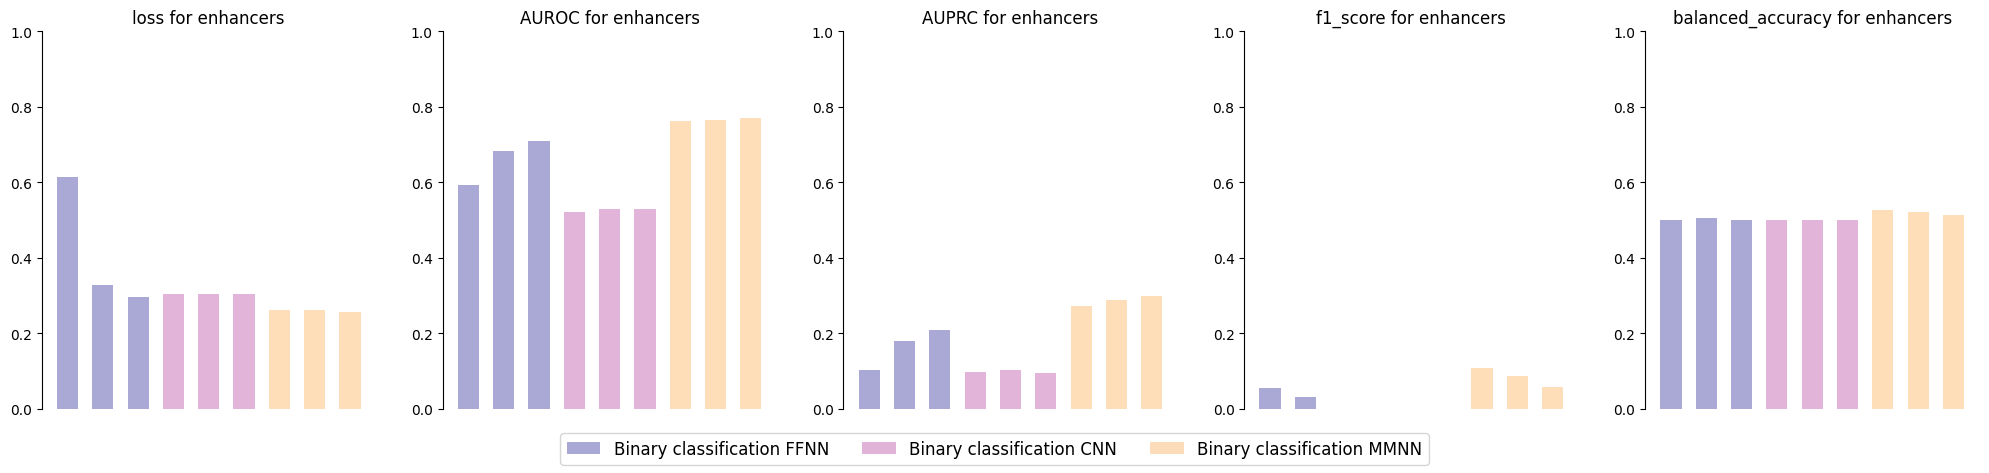

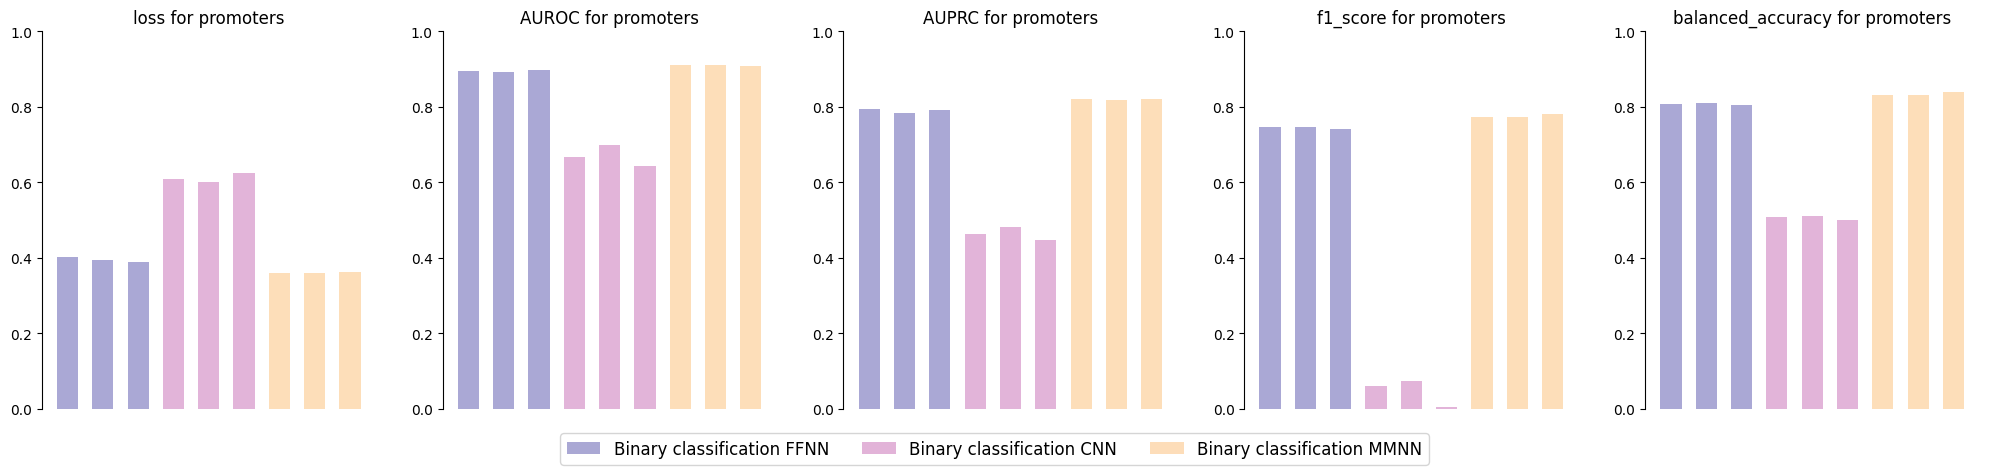

In [562]:
from matplotlib import cm
colors = [cm.plasma(i) for i in range(0,255,100)]
metrics = ['loss','AUROC','AUPRC','f1_score','balanced_accuracy']

for task in data.keys():
    fig, axs = plt.subplots(1, len(metrics),figsize=(25, 5), dpi=100)
    for j,metric in enumerate(metrics):
        v = []
        for i, (name, model) in enumerate(data[task]['evaluation'].items()):
            v.append(model['evaluations'][metric].values)
        for i, name in enumerate(data[task]['evaluation'].keys()): 
            r = range(i*number_of_holdouts,i*number_of_holdouts+number_of_holdouts)
            axs[j].bar(r, v[i], width=0.6,
                    alpha=0.35, color=colors[i], label=name)
        #axs[j].legend(loc=8, ncol=1, #labelcolor=colors, 
        #           framealpha=0.8, mode='expand', fontsize='large')
        axs[j].set_title(f'{metric} for {task}')
        axs[j].set_xticks([])
        axs[j].set_ylim(0,1)
        for dir in ['top','bottom','right']: axs[j].spines[dir].set_visible(False)
    handles, labels = axs[j].get_legend_handles_labels()
    fig.legend(handles, labels, loc=8, ncol=3,
                   framealpha=0.8, fontsize='large')
#plt.show()